# Méthode du synthetic control pour mesurer l'effet des "incentives" à la vaccination aux États-Unis

## 1. Définitions et analyse paramètres

In [1]:
import numpy as np
import pandas as pd

states = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

# On supprime le New Hampshire à cause d'irrégularités dans ses données vaccinales

states_names = {"AL":"Alabama", "AK":"Alaska", "AZ":"Arizona", "AR":"Arkansas",
                "CA":"California", "CO":"Colorado", "CT":"Connecticut",
                "DE":"Delaware", "FL":"Florida", "GA":"Georgia", "HI":"Hawaii",
                "ID":"Idaho", "IL":"Illinois", "IN":"Indiana", "IA":"Iowa",
                "KS":"Kansas", "KY":"Kentucky", "LA":"Louisiana", "ME":"Maine",
                "MD":"Maryland", "MA":"Massachusetts", "MI":"Michigan",
                "MN":"Minnesota", "MS":"Mississippi", "MO":"Missouri", "MT":"Montana",
                "NE":"Nebraska", "NV":"Nevada", "NH":"New Hampshire", "NJ":"New Jersey",
                "NM":"New Mexico", "NY":"New York", "NC":"North Carolina",
                "ND":"North Dakota", "OH":"Ohio", "OK":"Oklahoma", "OR":"Oregon",
                "PA":"Pennsylvania", "RI":"Rhode Island", "SC":"South Carolina",
                "SD":"South Dakota", "TN":"Tennessee", "TX":"Texas", "UT":"Utah",
                "VT":"Vermont", "VA":"Virginia", "WA":"Washington", "WV":"West Virginia",
                "WI":"Wisconsin", "WY":"Wyoming"}

In [2]:
# Importation des données de vaccination

df_states = {}
for X in states:
  # fichiers csv à trouver dans le drive partagé
    path = 'state_vax_csv/'+X+'.csv'
    df_states[X] = pd.read_csv(path, sep=',' )
    df_states[X] = df_states[X].loc[::-1].reset_index(drop=True)
    df_states[X] = df_states[X].loc[67:,:].reset_index()

In [3]:
df_states['AK'].loc[:,["Date", "Administered_Dose1_Pop_Pct", 'Administered_Dose1_Recip_12_17_Pct','Administered_Dose1_Recip_18_64_Pct','Administered_Dose1_Recip_65PlusPop_Pct']]

Date  Administered_Dose1_Pop_Pct  \
0    02/19/2021                        19.7   
1    02/20/2021                        20.3   
2    02/21/2021                        20.9   
3    02/22/2021                        21.0   
4    02/23/2021                        21.1   
..          ...                         ...   
448  05/13/2022                        69.8   
449  05/14/2022                        69.8   
450  05/15/2022                        69.8   
451  05/16/2022                        69.8   
452  05/17/2022                        69.9   

     Administered_Dose1_Recip_12_17_Pct  Administered_Dose1_Recip_18_64_Pct  \
0                                   0.0                                31.2   
1                                   0.0                                32.2   
2                                   0.0                                33.0   
3                                   0.0                                33.3   
4                                   0.0                                33.5   
..                                  ...                                 ...   
448                                62.9                                79.4   
449                                63.0                                79.4   
450                                63.0                                79.4   
451                                63.0                                79.4   
452                                63.0                                79.4   

     Administered_Dose1_Recip_65PlusPop_Pct  
0                                       0.0  
1                                       0.0  
2                                       0.0  
3                                       0.0  
4                                       0.0  
..                                      ...  
448                                    95.0  
449                                    95.0  
450                                    95.0  
451                                    95.0  
452                                    95.0  

[453 rows x 5 columns]

In [4]:
# On remarque qu'il y a des problèmes dans le report des doses administrées : il arrive que le pourcentage de doses
# administrées diminue, alors qu'il ne devrait qu'augmenter ou rester constant (cf. explications dans le rapport)
# On décide donc de remédier à ces erreurs en fixant un seuil pour éviter que les données ne diminuent
# Dans un second temps, on effectue une interpolation sur la période où l'on constate des erreurs de report

tf = len(df_states['CA'])

for seg in ["Administered_Dose1_Pop_Pct", "Administered_Dose1_Recip_12_17_Pct", "Administered_Dose1_Recip_18_64_Pct", "Administered_Dose1_Recip_65PlusPop_Pct"]:
    for state in states:
        for t in range(1,tf):
            if df_states[state].loc[t, seg] < df_states[state].loc[t-1, seg]:
                #on a un souci à partir du temps t
                j = t
                flag = True
                while j < tf and flag:
                    if df_states[state].loc[j, seg] >= df_states[state].loc[t-1, seg]:
                        #on a trouvé le plus petit indice pour lequel les données redeviennent cohérentes
                        a_t = df_states[state].loc[t-1, seg]
                        a_j = df_states[state].loc[j, seg]
                        
                        #on interpole linéairement
                        for i in range(t,j):
                            df_states[state].loc[i, seg] = ((a_t-a_j)/(t-1-j))*(i-j) + a_j
                        flag = False
                    j +=1 
                        
                if flag:
                    #on a pas trouvé de plus petit indice: on crée un plateau à partir du temps t
                    for i in range(t,tf):
                        df_states[state].loc[i, seg] = df_states[state].loc[t-1, seg]

In [5]:
# On s'intéresse à la colonne du pourcentage de personnes ayant reçu au moins une dose. 
# C'est notre "response variable" que l'on cherche à modéliser après l'intervention.

df_dose1 = {"All":{} ,"12-17":{}, "18-64":{}, "65Plus":{}}

for X in states:
    df_dose1["All"][X] = df_states[X].loc[:,'Administered_Dose1_Pop_Pct']
    df_dose1["12-17"][X] = df_states[X].loc[:,'Administered_Dose1_Recip_12_17_Pct']
    df_dose1["18-64"][X] = df_states[X].loc[:,'Administered_Dose1_Recip_18_64_Pct']
    df_dose1["65Plus"][X] = df_states[X].loc[:,'Administered_Dose1_Recip_65PlusPop_Pct']

ls_dose1 = {"All":{} ,"12-17":{}, "18-64":{}, "65Plus":{}}
for k in ["All", "12-17", "18-64", "65Plus"]:
    for X in states:
        ls_dose1[k][X] = df_dose1[k][X].to_numpy()

In [6]:
df_prm = pd.read_excel('parameters.xlsx', 'By state code', index_col=0)
df_prm = df_prm.drop(columns=['Population'])
prm = df_prm.to_numpy()
    
state_vector = {}
for i in range(len(states)):
    state_vector[states[i]] = prm[i]

In [7]:
df_prm.to_csv('CSV_results/df_prm.csv', ',')
df_prm.head()

Under 18 years old  Over 65 years old  Median age   White   Black  \
State code                                                                      
AL                       0.222              0.178        39.0  0.6809  0.2664   
AK                       0.246              0.131        34.0  0.6458  0.0328   
AZ                       0.225              0.185        38.0  0.7722  0.0450   
AR                       0.232              0.177        38.0  0.7672  0.1532   
CA                       0.225              0.152        37.0  0.5970  0.0579   

            American Indian   Asian  Hawaiian  Higher education achievement  \
State code                                                                    
AL                   0.0052  0.0136    0.0005                          0.26   
AK                   0.1489  0.0623    0.0125                          0.30   
AZ                   0.0450  0.0331    0.0021                          0.30   
AR                   0.0068  0.0152    0.0029                          0.23   
CA                   0.0077  0.1449    0.0040                          0.34   

            High school achievement  ...  Median income (in USD)  \
State code                           ...                           
AL                             0.86  ...                 50536.0   
AK                             0.93  ...                 77640.0   
AZ                             0.87  ...                 58945.0   
AR                             0.87  ...                 47597.0   
CA                             0.83  ...                 75235.0   

            2016 Trump vote share  2020 Trump vote share  \
State code                                                 
AL                         0.6208                  0.620   
AK                         0.5128                  0.528   
AZ                         0.4867                  0.491   
AR                         0.6057                  0.624   
CA                         0.3162                  0.343   

            Governor: democrat (1) / republican (0)  Gun ownership rate  \
State code                                                                
AL                                              0.0               0.555   
AK                                              0.0               0.645   
AZ                                              0.0               0.463   
AR                                              0.0               0.572   
CA                                              1.0               0.283   

            Adult obesity rate  Hypertension  \
State code                                     
AL                       0.361         0.425   
AK                       0.305         0.328   
AZ                       0.314         0.325   
AR                       0.374         0.410   
CA                       0.262         0.278   

            Number of Covid-19 deaths in 2020 / State population  \
State code                                                         
AL                                                   0.000021      
AK                                                   0.000050      
AZ                                                   0.000013      
AR                                                   0.000030      
CA                                                   0.000002      

            People without healthcare  Access to care score  
State code                                                   
AL                              0.097              0.136664  
AK                              0.115              0.577950  
AZ                              0.111              0.286535  
AR                              0.091              0.267585  
CA                              0.078              0.574505  

[5 rows x 30 columns]

In [8]:
# Normalisation et moyenne à 0

df_prm_scaled = (df_prm-df_prm.mean())/df_prm.std()
prm_scaled = df_prm_scaled.to_numpy()

state_vector_scaled = {}
for i in range(len(states)):
    state_vector_scaled[states[i]] = prm_scaled[i]

In [9]:
df_prm_scaled.to_csv('CSV_results/df_prm_scaled.csv', ',')
df_prm_scaled.head()

Under 18 years old  Over 65 years old  Median age     White  \
State code                                                                
AL                   -0.009301           0.196143    0.159599 -0.655402   
AK                    1.230784          -2.204567   -1.940392 -0.930504   
AZ                    0.145710           0.553696   -0.260399  0.060178   
AR                    0.507401           0.145064   -0.260399  0.020989   
CA                    0.145710          -1.131909   -0.680397 -1.312982   

               Black  American Indian     Asian  Hawaiian  \
State code                                                  
AL          1.685610        -0.386748 -0.518640 -0.211357   
AK         -0.769213         4.502030  0.359097  0.632946   
AZ         -0.641007         0.967277 -0.167184 -0.098783   
AR          0.496030        -0.332314 -0.489802 -0.042497   
CA         -0.505445        -0.301696  1.847825  0.034898   

            Higher education achievement  High school achievement  ...  \
State code                                                         ...   
AL                             -1.012667                -1.320839  ...   
AK                             -0.245495                 1.247459  ...   
AZ                             -0.245495                -0.953939  ...   
AR                             -1.588047                -0.953939  ...   
CA                              0.521677                -2.421538  ...   

            Median income (in USD)  2016 Trump vote share  \
State code                                                  
AL                       -1.175728               1.256236   
AK                        1.458899               0.199490   
AZ                       -0.358336              -0.055890   
AR                       -1.461411               1.108487   
CA                        1.225123              -1.724178   

            2020 Trump vote share  Governor: democrat (1) / republican (0)  \
State code                                                                   
AL                       1.152518                                -0.951113   
AK                       0.261945                                -0.951113   
AZ                      -0.096221                                -0.951113   
AR                       1.191238                                -0.951113   
CA                      -1.528882                                 1.030372   

            Gun ownership rate  Adult obesity rate  Hypertension  \
State code                                                         
AL                    0.864443            0.961142      2.157888   
AK                    1.547017           -0.511872     -0.072665   
AZ                    0.166700           -0.275138     -0.141652   
AR                    0.993373            1.303091      1.812957   
CA                   -1.198449           -1.642936     -1.222435   

            Number of Covid-19 deaths in 2020 / State population  \
State code                                                         
AL                                                  -0.244389      
AK                                                   0.576988      
AZ                                                  -0.498358      
AR                                                   0.015860      
CA                                                  -0.811085      

            People without healthcare  Access to care score  
State code                                                   
AL                           0.401891             -1.630616  
AK                           0.989070              0.358003  
AZ                           0.858586             -0.955236  
AR                           0.206165             -1.040629  
CA                          -0.217909              0.342477  

[5 rows x 30 columns]

In [10]:
# Matrice des corrélations

df_prm_corr = df_prm_scaled.corr()
df_prm_corr.to_csv('CSV_results/df_prm_corr.csv', ',')
df_prm_corr.head()

Under 18 years old  Over 65 years old  Median age  \
Under 18 years old            1.000000          -0.783883   -0.913930   
Over 65 years old            -0.783883           1.000000    0.883972   
Median age                   -0.913930           0.883972    1.000000   
White                        -0.063072           0.201119    0.179586   
Black                         0.016944          -0.104766    0.017228   

                       White     Black  American Indian     Asian  Hawaiian  \
Under 18 years old -0.063072  0.016944         0.311793 -0.100505 -0.006747   
Over 65 years old   0.201119 -0.104766        -0.198845 -0.025524  0.071442   
Median age          0.179586  0.017228        -0.364334 -0.037116 -0.066593   
White               1.000000 -0.536897         0.015582 -0.717981 -0.593799   
Black              -0.536897  1.000000        -0.330084 -0.103482 -0.178020   

                    Higher education achievement  High school achievement  \
Under 18 years old                     -0.309742                -0.134407   
Over 65 years old                      -0.087218                 0.173716   
Median age                              0.117245                 0.120762   
White                                  -0.048032                 0.412510   
Black                                  -0.170789                -0.543158   

                    ...  Median income (in USD)  2016 Trump vote share  \
Under 18 years old  ...               -0.131387               0.414463   
Over 65 years old   ...               -0.246880              -0.054832   
Median age          ...               -0.059406              -0.205970   
White               ...               -0.264011               0.351152   
Black               ...               -0.213725               0.080447   

                    2020 Trump vote share  \
Under 18 years old               0.520524   
Over 65 years old               -0.121539   
Median age                      -0.315887   
White                            0.349000   
Black                            0.001303   

                    Governor: democrat (1) / republican (0)  \
Under 18 years old                                -0.328714   
Over 65 years old                                  0.159378   
Median age                                         0.256799   
White                                             -0.170398   
Black                                             -0.055521   

                    Gun ownership rate  Adult obesity rate  Hypertension  \
Under 18 years old            0.390922           -0.189033     -0.052678   
Over 65 years old            -0.092461            0.273851      0.192577   
Median age                   -0.251097            0.263279      0.205389   
White                         0.403850            0.096187     -0.112120   
Black                        -0.072271           -0.050979      0.515578   

                    Number of Covid-19 deaths in 2020 / State population  \
Under 18 years old                                           0.138105      
Over 65 years old                                            0.061694      
Median age                                                  -0.152315      
White                                                        0.253897      
Black                                                       -0.251893      

                    People without healthcare  Access to care score  
Under 18 years old                   0.510472             -0.498972  
Over 65 years old                   -0.358531              0.284428  
Median age                          -0.405454              0.343940  
White                               -0.113271              0.171361  
Black                                0.249545             -0.458075  

[5 rows x 30 columns]

In [11]:
# Définitions des états traités

incentives = pd.read_csv('incentive_list_updated.csv', index_col=None)

incentives_grp = {}
incentives_grp["18+"] = incentives.loc[incentives["Condition"] != "12-17", :]
incentives_grp["12-17"] = incentives.loc[incentives["Condition"] != "18+", :]

target_states_all = {}
target_states_all["18+"] = set(incentives_grp["18+"]["State code"])  
target_states_all["12-17"] = set(incentives_grp["12-17"]["State code"])
    
control_states_all = {}
control_states_all["18+"] = [X for X in states if not (X in target_states_all["18+"])]
control_states_all["12-17"] = [X for X in states if not (X in target_states_all["12-17"])]

control_states_names = {}
control_states_names["18+"] = [states_names[X] for X in control_states_all["18+"]]
control_states_names["12-17"] = [states_names[X] for X in control_states_all["12-17"]]

In [14]:
# Importations des données relatives aux incentives

dates = {"18+":{}, "12-17":{}}
category = {}
for X in target_states_all["18+"]:
    dates["18+"][X] = incentives_grp["18+"].loc[incentives_grp["18+"]["State code"] == X, "Incentive t0"]
    dates["18+"][X] = dates["18+"][X].iloc[0]
for X in target_states_all["12-17"]:
    dates["12-17"][X] = incentives_grp["12-17"].loc[incentives_grp["12-17"]["State code"] == X, "Incentive t0"]
    dates["12-17"][X] = dates["12-17"][X].iloc[0]    

### Clustering K-means et interprétation

['California', 'Colorado', 'Connecticut', 'Delaware', 'Hawaii', 'Idaho', 'Massachusetts', 'Maryland', 'Maine', 'Michigan', 'Minnesota', 'Nebraska', 'New Jersey', 'Nevada', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'Vermont', 'Washington', 'Wisconsin', 'Wyoming'] 21
['Alaska', 'Arkansas', 'Arizona', 'Florida', 'Georgia', 'Illinois', 'Kentucky', 'Louisiana', 'Missouri', 'Mississippi', 'North Dakota', 'New Mexico', 'New York', 'Oklahoma', 'Oregon', 'South Dakota', 'Texas', 'Utah', 'West Virginia'] 19
['Alabama', 'Iowa', 'Indiana', 'Kansas', 'Montana', 'North Carolina', 'Ohio', 'Tennessee', 'Virginia'] 9
[] 0


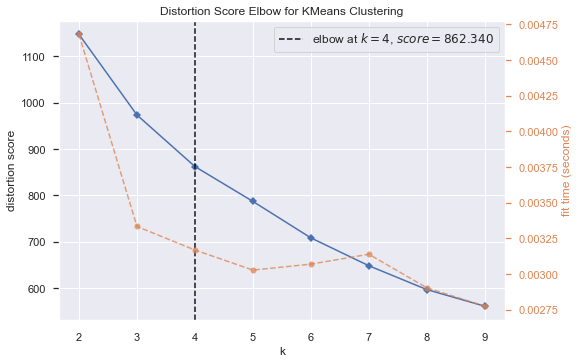

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [85]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Nombre de groupes
n = 3

km = KMeans(
    n_clusters= n, init='random',
    n_init=10, max_iter=300, 
    tol=1e-05, random_state=0
)

y_km = km.fit_predict(df_prm_scaled)

states_A, states_B, states_C, states_D = [], [], [], []
states_A_names, states_B_names, states_C_names, states_D_names = [], [], [], []
for i in range(len(states)):
    if y_km[i] == 0:
        states_A_names.append(states_names[states[i]])
        states_A.append(states[i])
    elif y_km[i] == 1:
        states_B_names.append(states_names[states[i]])
        states_B.append(states[i])
    elif y_km[i] == 2 and n >= 3:
        states_C_names.append(states_names[states[i]])
        states_C.append(states[i])
    elif y_km[i] == 3 and n>= 4:
        states_D_names.append(states_names[states[i]])
        states_D.append(states[i])

group_states = {}

for X in states:
  if X in states_A:
    group_states[X] = 'A'
  if X in states_B:
    group_states[X] = 'B'
  if X in states_C:
    group_states[X] = 'C'
  if X in states_D:
    group_states[X] = 'D'

print(states_A_names, len(states_A_names))
print(states_B_names, len(states_B_names))
print(states_C_names, len(states_C_names))
print(states_D_names, len(states_D_names))

# Elbow method K-means
visualizer = KElbowVisualizer(km, k=(2,10))

visualizer.fit(df_prm_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [86]:
target_states = {'A': [], 'B': [], 'C':[], 'D':[]}
control_states = {'A': [], 'B': [], 'C':[], 'D':[]}

for X in states:
    if X in states_A and X in target_states_all:
        target_states['A'].append(X)
    elif X in states_A and X not in target_states_all:
        control_states['A'].append(X)
    elif X in states_B and X in target_states_all:
        target_states['B'].append(X)
    elif X in states_B and X not in target_states_all:
        control_states['B'].append(X)
    elif X in states_C and X in target_states_all:
        target_states['C'].append(X)
    elif X in states_C and X not in target_states_all:
        control_states['C'].append(X)
    elif X in states_D and X in target_states_all:
        target_states['D'].append(X)
    elif X in states_D and X not in target_states_all:
        control_states['D'].append(X)



print("Number of potential target states in group A = " + str(len(target_states['A'])) + "/" + str(len(states)))
print("Number of control states in group A = " + str(len(control_states['A'])) + "/" + str(len(states)))
print("Number of potential target states in group B = " + str(len(target_states['B'])) + "/" + str(len(states)))
print("Number of control states in group B = " + str(len(control_states['B'])) + "/" + str(len(states)))
print("Number of potential target states in group C = " + str(len(target_states['C'])) + "/" + str(len(states)))
print("Number of control states in group C = " + str(len(control_states['C'])) + "/" + str(len(states)))
print("Number of potential target states in group D = " + str(len(target_states['D'])) + "/" + str(len(states)))
print("Number of control states in group D = " + str(len(control_states['D'])) + "/" + str(len(states)))

Number of potential target states in group A = 13/49
Number of control states in group A = 8/49
Number of potential target states in group B = 10/49
Number of control states in group B = 9/49
Number of potential target states in group C = 4/49
Number of control states in group C = 5/49
Number of potential target states in group D = 0/49
Number of control states in group D = 0/49


Pourcentage des états ayant voté Trump en 2016 dans le groupe A: 19.047619047619047%
Pourcentage des états ayant voté Trump en 2016 dans le groupe B: 63.16%
Pourcentage des états ayant voté Trump en 2016 dans le groupe C: 77.78%
Pourcentage des états ayant voté Trump en 2016 dans le groupe D: nan%


/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_9410/2343322642.py:39: RuntimeWarning:

invalid value encountered in double_scalars



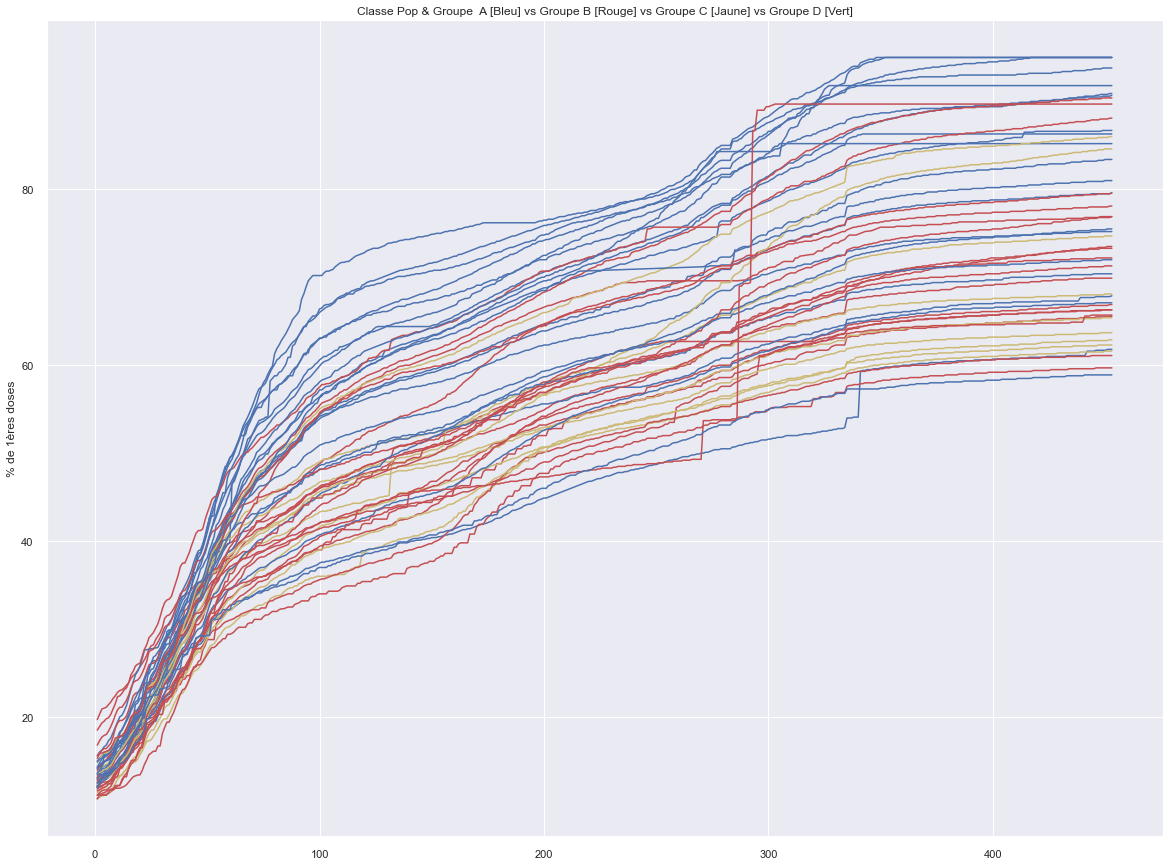

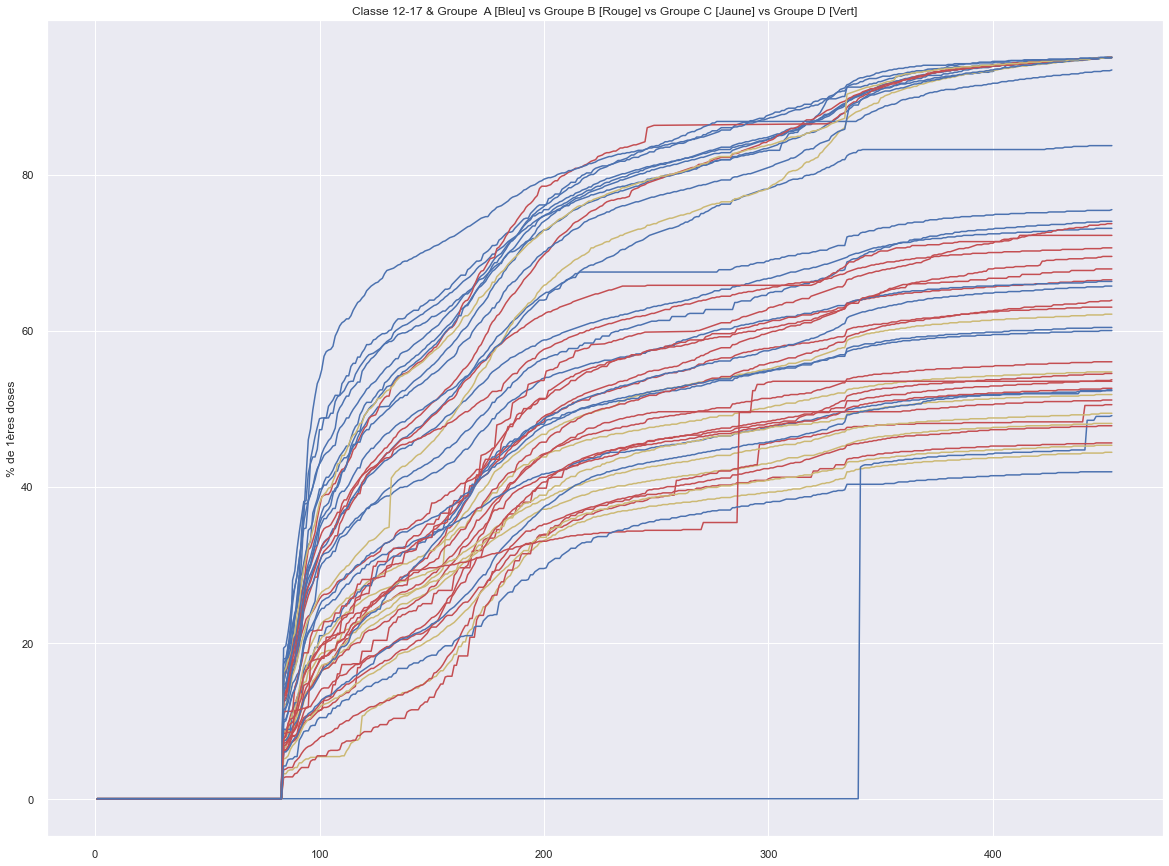

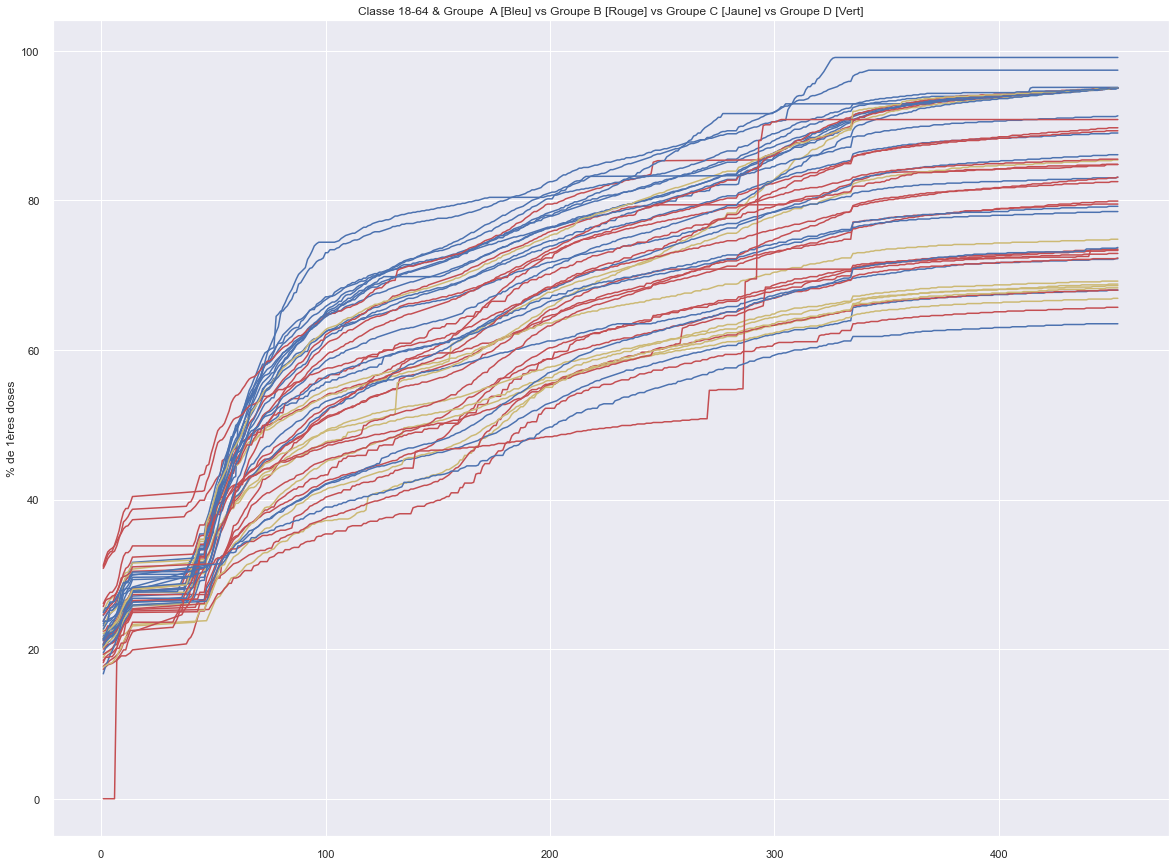

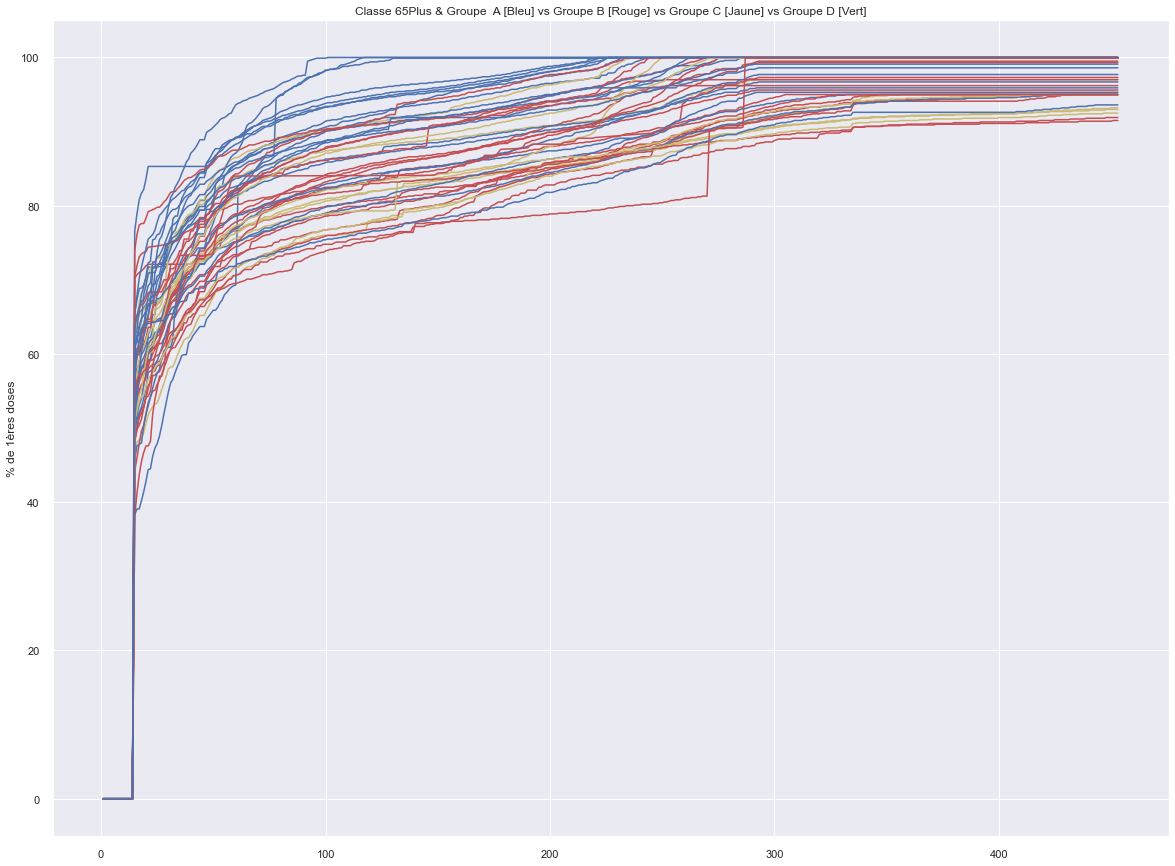

In [87]:
# Interprétation des groupes
# Remarque: même en supprimant les paramètres "politiques" (vote Trump 2020, 2016, ...)
#           le clustering génère les mêmes groupes. 

import matplotlib.pyplot as plt

vote_A, vote_B, vote_C, vote_D = [], [], [], []
states_A = np.concatenate((target_states['A'], control_states['A']))
states_B = np.concatenate((target_states['B'], control_states['B']))
states_C = np.concatenate((target_states['C'], control_states['C']))
states_D = np.concatenate((target_states['D'], control_states['D']))

for X in states_A:
    if df_prm.loc[X, "2016 Trump vote share"] >= 0.5:
        vote_A.append(1)
    else:
        vote_A.append(0)       
pct_A = 100*np.sum(vote_A)/len(vote_A)

for X in states_B:
    if df_prm.loc[X, "2016 Trump vote share"] >= 0.5:
        vote_B.append(1)
    else:
        vote_B.append(0)
pct_B = 100*np.sum(vote_B)/len(vote_B)

for X in states_C:
    if df_prm.loc[X, "2016 Trump vote share"] >= 0.5:
        vote_C.append(1)
    else:
        vote_C.append(0)
pct_C = 100*np.sum(vote_C)/len(vote_C)

for X in states_D:
    if df_prm.loc[X, "2016 Trump vote share"] >= 0.5:
        vote_D.append(1)
    else:
        vote_D.append(0)
pct_D = 100*np.sum(vote_D)/len(vote_D)
        
print("Pourcentage des états ayant voté Trump en 2016 dans le groupe A: "+str(pct_A)+"%")
print("Pourcentage des états ayant voté Trump en 2016 dans le groupe B: "+str(np.round(pct_B,2))+"%")
print("Pourcentage des états ayant voté Trump en 2016 dans le groupe C: "+str(np.round(pct_C,2))+"%")
print("Pourcentage des états ayant voté Trump en 2016 dans le groupe D: "+str(np.round(pct_D,2))+"%")

for k in ["All","12-17","18-64","65Plus"]:
    plt.figure(figsize=(20,15))
    for X in states:
        c = 0
        if X in states_A:
            c = 'b'
        elif X in states_B:
            c = 'r'
        elif X in states_C:
            c = 'y'
        elif X in states_D:
            c = 'g'

        t = np.linspace(1,len(ls_dose1[k][X]), len(ls_dose1[k][X]))
        plt.plot(t, ls_dose1[k][X], color=c)
        
    plt.ylabel('% de 1ères doses')
    plt.title('Classe '+k+' & Groupe  A [Bleu] vs Groupe B [Rouge] vs Groupe C [Jaune] vs Groupe D [Vert]')
plt.show()


# Carte 
import plotly.express as px

c_list = []
for X in states:
    if X in states_A:
        c_list.append(1)
    elif X in states_B:
        c_list.append(2)
    elif X in states_C:
        c_list.append(3)
    elif X in states_D:
        c_list.append(4)    
    
fig = px.choropleth(locations=states, locationmode="USA-states", color=c_list, scope="usa")
fig.show()

### Logistic regression

Delaware


/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_9410/1660531051.py:6: RuntimeWarning:

overflow encountered in exp

/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



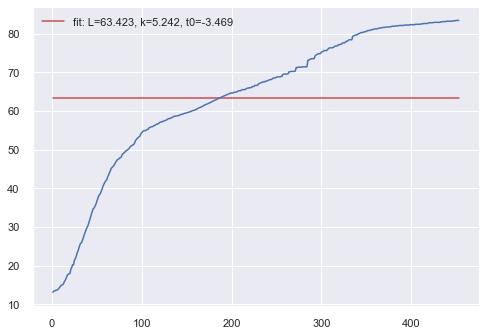

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_9410/1660531051.py:6: RuntimeWarning:

overflow encountered in exp



Kansas


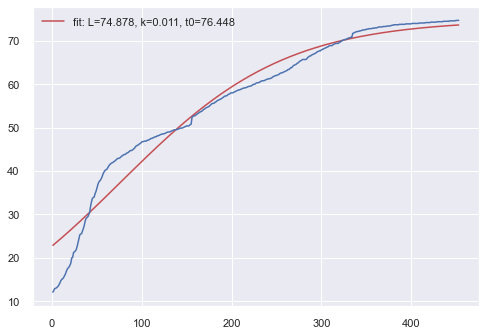

Kentucky


/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_9410/1660531051.py:6: RuntimeWarning:

overflow encountered in exp



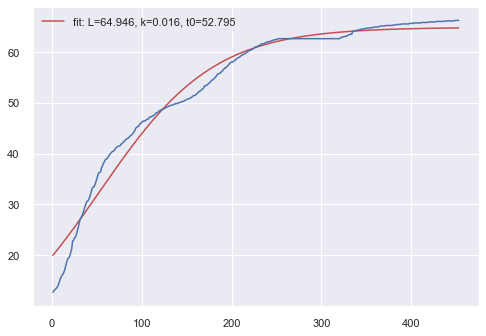

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_9410/1660531051.py:6: RuntimeWarning:

overflow encountered in exp



Oregon


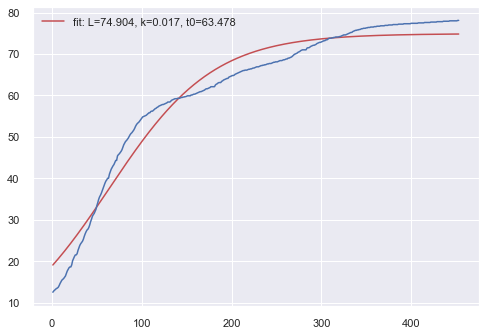

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_9410/1660531051.py:6: RuntimeWarning:

overflow encountered in exp

/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



California


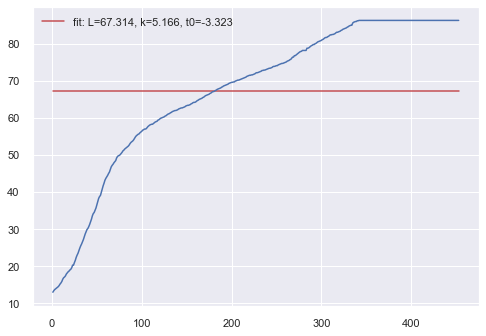

Arkansas


/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_9410/1660531051.py:6: RuntimeWarning:

overflow encountered in exp



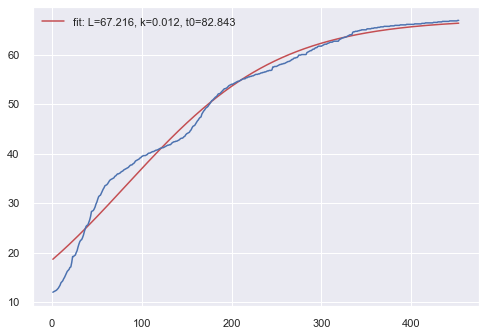

Nevada


/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_9410/1660531051.py:6: RuntimeWarning:

overflow encountered in exp



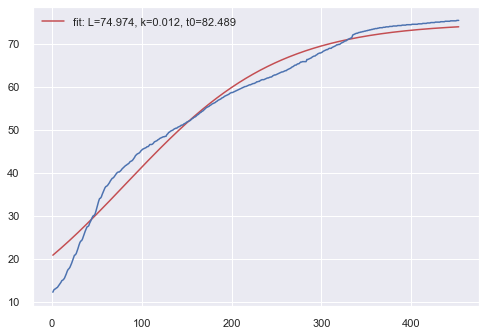

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_9410/1660531051.py:6: RuntimeWarning:

overflow encountered in exp



Ohio


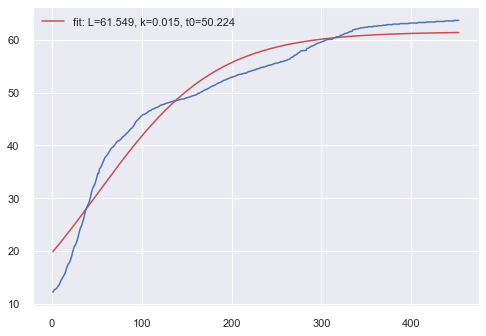

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_9410/1660531051.py:6: RuntimeWarning:

overflow encountered in exp



Missouri


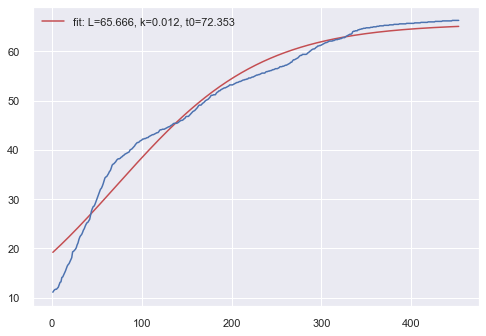

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_9410/1660531051.py:6: RuntimeWarning:

overflow encountered in exp

/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



Massachusetts


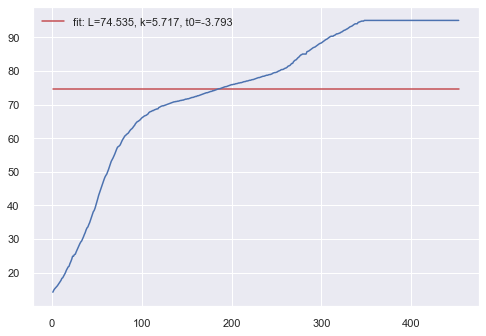

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_9410/1660531051.py:6: RuntimeWarning:

overflow encountered in exp



North Carolina


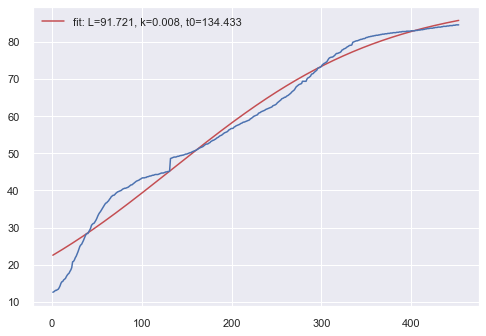

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_9410/1660531051.py:6: RuntimeWarning:

overflow encountered in exp



Colorado


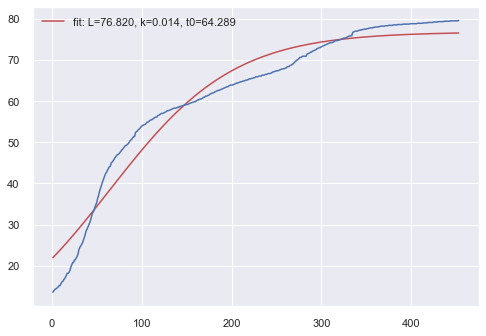

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_9410/1660531051.py:6: RuntimeWarning:

overflow encountered in exp

/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



Maine


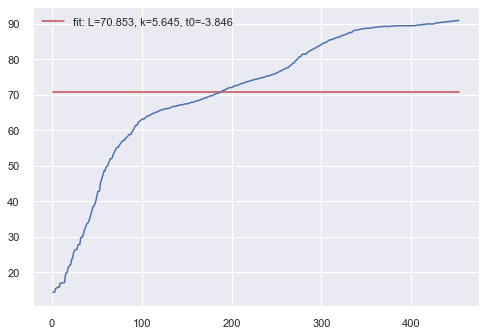

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_9410/1660531051.py:6: RuntimeWarning:

overflow encountered in exp

/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



Washington


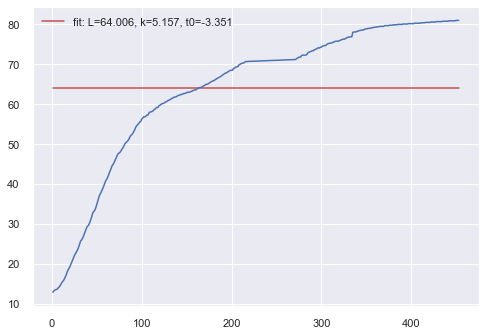

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_9410/1660531051.py:6: RuntimeWarning:

overflow encountered in exp

/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



Maryland


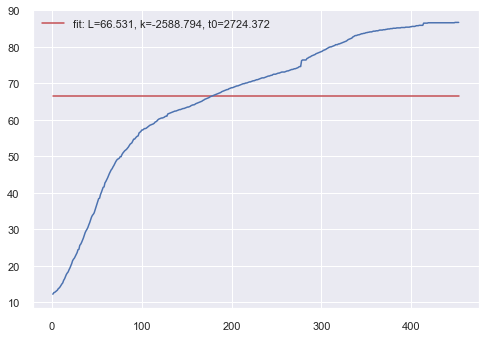

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_9410/1660531051.py:6: RuntimeWarning:

overflow encountered in exp



Alabama


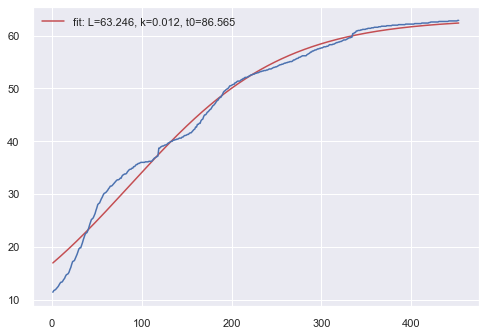

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_9410/1660531051.py:6: RuntimeWarning:

overflow encountered in exp

/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



Alaska


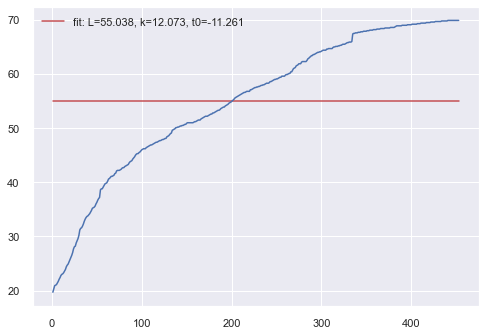

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_9410/1660531051.py:6: RuntimeWarning:

overflow encountered in exp

/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



West Virginia


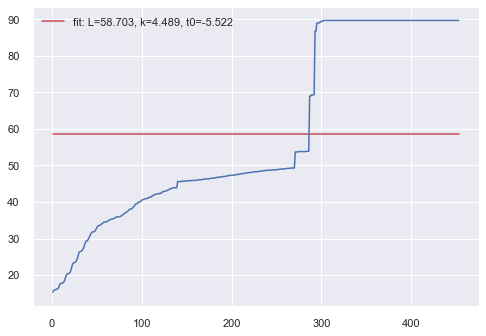

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_9410/1660531051.py:6: RuntimeWarning:

overflow encountered in exp



Illinois


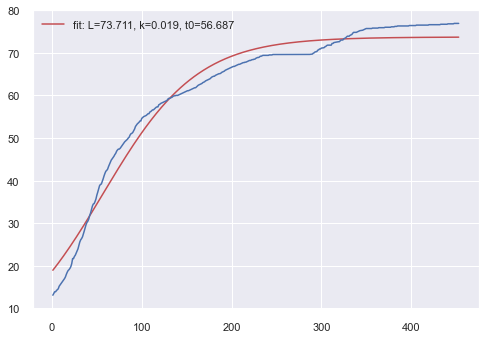

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_9410/1660531051.py:6: RuntimeWarning:

overflow encountered in exp

/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



New York


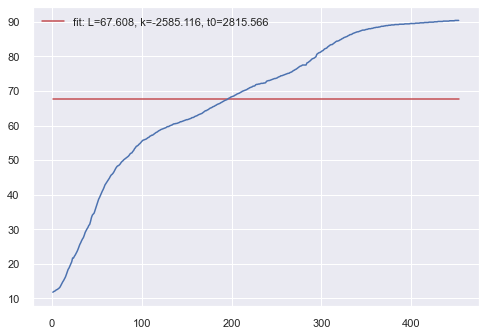

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_9410/1660531051.py:6: RuntimeWarning:

overflow encountered in exp



Connecticut


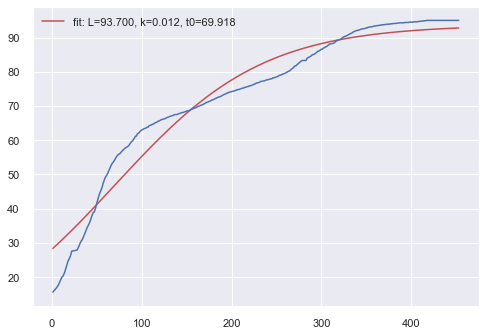

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_9410/1660531051.py:6: RuntimeWarning:

overflow encountered in exp



Michigan


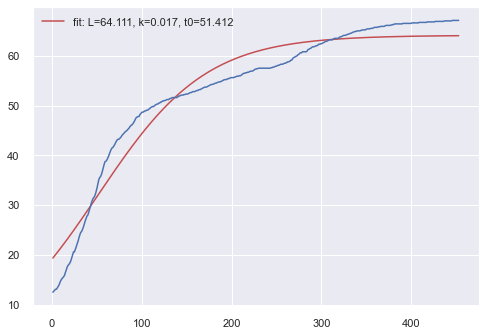

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_9410/1660531051.py:6: RuntimeWarning:

overflow encountered in exp



Hawaii


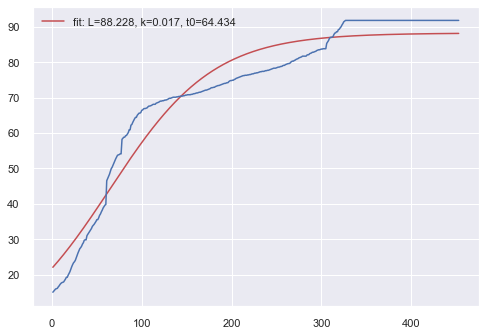

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_9410/1660531051.py:6: RuntimeWarning:

overflow encountered in exp

/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



New Jersey


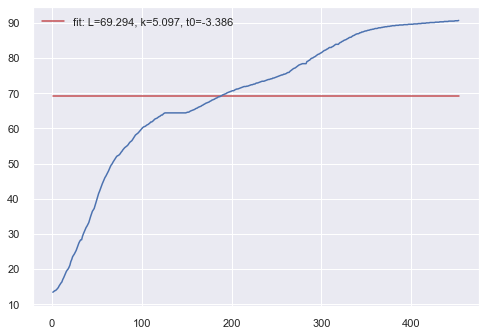

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_9410/1660531051.py:6: RuntimeWarning:

overflow encountered in exp



Minnesota


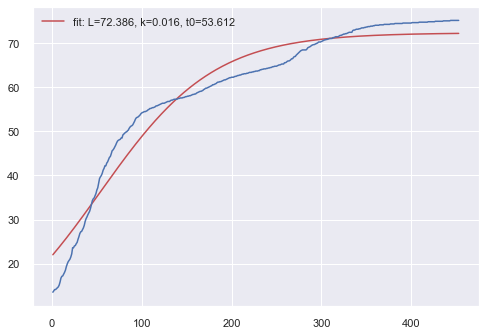

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_9410/1660531051.py:6: RuntimeWarning:

overflow encountered in exp

/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



New Mexico


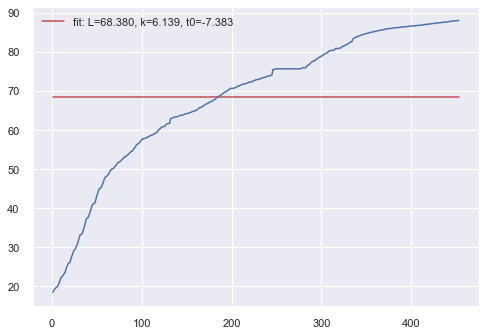

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_9410/1660531051.py:6: RuntimeWarning:

overflow encountered in exp

/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



Louisiana


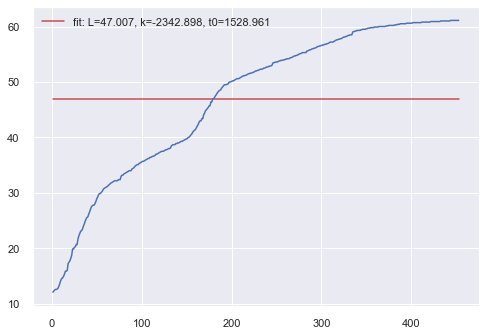

In [88]:
from scipy.optimize import curve_fit

for X in target_states_all:
  tspan = np.linspace(1,len(ls_dose1["All"][X]), len(ls_dose1["All"][X]))
  def func(t, L, k, tc):
    return L/(1+np.exp(-k*(t-tc)))

  popt, pcov = curve_fit(func, tspan, ls_dose1["All"][X])
  print(states_names[X])
  plt.plot(tspan, func(tspan, *popt), 'r-', label='fit: L=%5.3f, k=%5.3f, t0=%5.3f' % tuple(popt))
  plt.plot(tspan, ls_dose1["All"][X], 'b-')
  plt.legend()
  plt.show()

# 


## 2. Analyse en composantes principales
### Indépendant du synthetic control

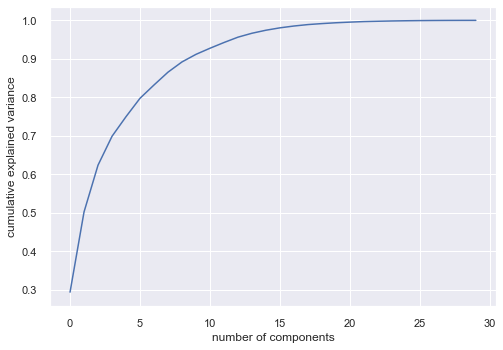

In [89]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA().fit(df_prm_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Text(0, 0.5, 'Percent Variance Explained')

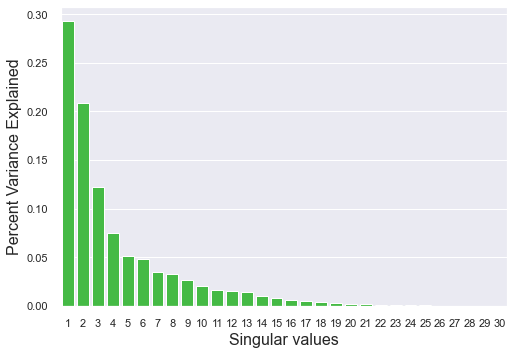

In [90]:
u, s, v = np.linalg.svd(df_prm_scaled, full_matrices=True)

v10 = v[:5,:]

var_explained = np.round(s**2/np.sum(s**2), decimals=3)
var_explained

import seaborn as sns; sns.set()
sns.barplot(x=list(range(1,len(var_explained)+1)),
            y=var_explained, color="limegreen")
plt.xlabel('Singular values', fontsize=16)
plt.ylabel('Percent Variance Explained', fontsize=16)

In [91]:
prm_scaled_t = np.transpose(prm_scaled)
prm_pca = np.transpose(np.dot(v10, prm_scaled_t))

state_vector_pca = {}
for i in range(len(states)):
    state_vector_pca[states[i]] = prm_pca[i]

# 

## 3. Retour au synthetic control

In [15]:
def norm(w, v, x, x1):
    pred = np.dot(np.transpose(x), w)
    pred_diff = x1 - pred
    pred_diff_v = np.multiply(pred_diff, v)
    res = np.dot(pred_diff, pred_diff_v)
    return np.sqrt(res)

L1 = 0.6
L2 = 0.1

def norm_reg(w, v, x, x1):
    pred = np.dot(np.transpose(x), w)
    pred_diff = x1 - pred
    pred_diff_v = np.multiply(pred_diff, v)
    res = np.sqrt(np.dot(pred_diff, pred_diff_v))
    res += L1*np.linalg.norm(w)
    res += L2*sum(np.abs(w))
    return res

def mspe(y1, y, w):
    interv = np.dot(np.transpose(y), w)
    interv_diff = y1 - interv
    res = np.dot(interv_diff, interv_diff)
    return res

In [16]:
# Définition des fonctions d'optimisation pour le contrôle synthétique

from scipy.optimize import minimize, fmin_slsqp

def constraint(w, v, x, x1):
    return np.sum(w) - 1

def con(v):
    return np.sum(v) - 1
cons = {'type':'eq', 'fun': con}

def mspe_opt_w(v_guess, w_guess, x, x1, y, y1):
    w_opt = fmin_slsqp(norm_reg, w_guess, f_eqcons=constraint, bounds=[(0.0, 1.0)]*len(w_guess),
             args=(v_guess, x, x1), disp=False)
    return mspe(y1, y, w_opt)

def opt_v(v_guess, w_guess, x, x1, y, y1):
    v_opt = minimize(mspe_opt_w, v_guess, constraints = cons, bounds=[(0.0, 1.0)]*len(v_guess), 
             args=(w_guess, x, x1, y, y1), method='SLSQP')
    return v_opt.x

def opt_w(w_guess, v, x, x1):
    w_opt = fmin_slsqp(norm_reg, w_guess, f_eqcons=constraint, bounds=[(0.0, 1.0)]*len(w_guess),
             args=(v, x, x1), disp=False)
    return w_opt

In [38]:
# Définition des dates de début des incentives par état

import datetime
inc_t0 = {}
inc_t0["All"] = {}
inc_t0["18-64"] = {}
inc_t0["65Plus"] = {}

for X in target_states_all["18+"]:
  # 19/02/2021 approx première date à laquelle les % de vax sont non nuls
  start = datetime.date(2021,2,19)
  t0_date_str = dates["18+"][X]
  t0_date = datetime.date(int(t0_date_str[6:]), int(t0_date_str[3:5]), int(t0_date_str[:2]))
  t0 = t0_date - start
  t0 = t0.days
  inc_t0["All"][X] = t0
  inc_t0["18-64"][X] = t0
  inc_t0["65Plus"][X] = t0

inc_t0["12-17"] = {}

for X in target_states_all["12-17"]:
  # 19/02/2021 approx première date à laquelle les % de vax sont non nuls
  start = datetime.date(2021,2,19)
  t0_date_str = dates["12-17"][X]
  t0_date = datetime.date(int(t0_date_str[6:]), int(t0_date_str[3:5]), int(t0_date_str[:2]))
  t0 = t0_date - start
  t0 = t0.days
  inc_t0["12-17"][X] = t0
  if inc_t0["All"][X] > t0:
    inc_t0["All"][X] = t0

In [18]:
# Contrôle synthétique

import random

y1_prediction = {}

# dfs={}
# dfs['A'] = pd.DataFrame(columns=control_states['A'])
# dfs['B'] = pd.DataFrame(columns=control_states['B'])
# dfs['C'] = pd.DataFrame(columns=control_states['C'])
# dfs['D'] = pd.DataFrame(columns=control_states['D'])

w_dic = {k:0 for k in target_states_all}

def synthetic(ls_dose1, state_vector_scaled, t_fit, t_test=10, states_choice=target_states_all, classe="Pop", plot=True):

  if classe == "12-17":
    states_choice = target_states_all["12-17"]
    control_choice = control_states_all["12-17"]
  else:
    states_choice = target_states_all["18+"]
    control_choice = control_states_all["18+"]

    
  V = []
  if plot==True:
    print("Les poids des différents états de contrôle dans le synthetic control: ")
    print("")
  
  ress = 0

  for Y in states_choice:
      
      X_target = Y
      if plot == True:
        print('The state of', states_names[X_target], 'is simulated with:')
      
      t0 = inc_t0[classe][X_target]

      # Defintion of control group
      control_states_all_temp = []

      incentives["Start Date"] = pd.to_datetime(incentives["Start Date"], format="%d/%m/%Y")
      start_dates = incentives.groupby(["State code"])["Start Date"].min()

      for X in states_choice:
          if start_dates.get(X) + datetime.timedelta(days=14) <= start_dates.get(Y) and X != Y:
              control_states_all_temp.append(X)

      if classe == "12-17":
        control_choice = control_states_all["12-17"] + control_states_all_temp
      else:
        control_choice = control_states_all["18+"] + control_states_all_temp
      sorted(control_choice)
      
      # L = "N/A"
      # if classe != "12-17":
      #   if X_target in states_A:
      #       L = 'A'
      #   elif X_target in states_B:
      #       L = 'B'
      #   elif X_target in states_C:
      #       L = 'C'
      #   elif X_target in states_D:
      #       L = 'D'
      
      y1 = ls_dose1[classe][X_target][t0-t_fit:t0-t_test]
      y = []
      for X in control_choice:    
          y.append(ls_dose1[classe][X][t0-t_fit:t0-t_test])

      y_post = []
      for X in control_choice:    
          y_post.append(ls_dose1[classe][X])

  #   Choisir ici state_vector_scaled (35 paramètres normalisés) 
  #   ou state_vector_pca (5 principaux paramètres du PCA).
  #       Il semble que les 35 paramètres normalisés génèrent un synthetic 
  #       plus proche du réel sur la période avant l'intervention.
      x1 = state_vector_scaled[X_target]

      x = []
      for X in control_choice :    
              x.append(state_vector_scaled[X])
      
      k = len(x)
      j = len(x1)

      # w_guess = np.array([1/k]*k)
      # v_guess = np.array([1/j]*j)

      w_guess = random.sample(range(0, 50), k)
      w_guess = np.array(w_guess)/sum(w_guess)
      v_guess = random.sample(range(0, 50), j)
      v_guess = np.array(v_guess)/sum(v_guess)
      
      v_star = 1/np.var(df_prm)
      
      v_star = opt_v(v_guess, w_guess, x, x1, y, y1)
      w_star = opt_w(w_guess, v_star, x, x1)

      w_star_dic = {}
      for i in len(control_choice):
        w_star_dic[control_choice[i]] = w_star[i]
      for X in states_choice:
        w_star_dic[X] = 0
      w_dic[Y] = w_star
      V.append(np.round(v_star, 3))
      
      

      y1_prediction[X_target] = np.dot(np.transpose(y_post), w_star)
      
      df_new_row = pd.DataFrame(data=np.array([w_star]), columns=control_choice)

      # dfs[L]= pd.concat([dfs[L],df_new_row], ignore_index=True)
      
      inf = 0.01
      states_star = {}
      
      for k in range(len(w_star)):
          if w_star[k]>inf:
              states_star[control_choice[k]] = w_star[k]
      
      sortedDict = sorted(states_star.items(), key=lambda x: x[1], reverse=True)
      

      if plot == True:
        for k in range(len(sortedDict)):
          print('   ', states_names[sortedDict[k][0]],np.round(sortedDict[k][1],3)*100,'%' )

        t = np.linspace(1,len(ls_dose1[classe][X_target]), len(ls_dose1[classe][X_target]))
        t_zoom = np.linspace(t0-40,t0+70, 110)
        
        plt.figure(figsize=(20, 16))
        plt.subplot(2, 2, 1) # row 1, col 2 index 1
        plt.plot(t, ls_dose1[classe][X_target], label='real')
        plt.plot(t, y1_prediction[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.axvspan(t0-t_fit, t0-t_test,color='blue',alpha=0.05, label= "fit timespan")
        plt.legend()
        plt.title(states_names[X_target])


        plt.subplot(2, 2, 2) # row 1, col 2 index 1
        plt.plot(t_zoom, ls_dose1[classe][X_target][t0-40:t0+70], label='real')
        plt.plot(t_zoom, y1_prediction[X_target][t0-40:t0+70], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.axvspan(max(t0-t_fit,t0-40), t0-t_test,color='blue',alpha=0.05, label= "fit timespan")
        plt.legend()
        plt.title(states_names[X_target] + ' [zoom]')
        

        plt.subplot(2, 2, 3) # row 1, col 2 index 1
        for X in control_choice:
            if X != X_target:
                plt.plot(t, ls_dose1[classe][X], 'y--', linewidth=0.5)
        plt.plot(t, ls_dose1[classe][X_target], label='real')
        plt.plot(t, y1_prediction[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.axvspan(t0-t_fit, t0-t_test,color='blue',alpha=0.05, label= "fit timespan")
        plt.legend()
        plt.title(states_names[X_target]+' vs autres états')

        # plt.subplot(2, 2, 4) # row 1, col 2 index 1
        # for i in range(len(control_states_all)):
        #     X = control_states_all[i]
        #     if X != X_target:
        #       if X in control_states[L]:
        #         th = 2*w_star[i]
        #         plt.plot(t, ls_dose1[classe][X], 'g', linewidth=th)
        #       else:
        #         th = 2*w_star[i]
        #         plt.plot(t, ls_dose1[classe][X], 'r', linewidth=th)
        # plt.plot(t, ls_dose1[classe][X_target], label='real')
        # plt.plot(t, y1_prediction[X_target], label='synthetic')
        # lbl = "t0=" + t0_date_str
        # plt.axvline(x=t0, ls='--', label= lbl)
        # plt.axvspan(t0-t_fit, t0-t_test,color='blue',alpha=0.05, label= "fit timespan")
        # plt.legend()
        # plt.title(states_names[X_target]+' vs états contrôles finaux')

        plt.show()
        print('')

      if not plot:
        ress +=1
        print(str(np.round(100*ress/len(states_choice),2))+'% complete',end="\r")
  return V

In [19]:
import time


first_date = str(df_states['AK'].loc[0,["Date"]].values[0])
last_date = str(df_states['AK'].loc[len(df_states['AK'].loc[:,['Date']])-1,["Date"]].values[0])
print(first_date,last_date)

date_span = pd.date_range(start=first_date, end=last_date)

02/19/2021 05/17/2022


In [97]:
for classe in ["All", "12-17", "18-64", "65Plus"]:
    df1 = pd.DataFrame(ls_dose1[classe], index=date_span)
    df1.to_csv('CSV_results/doses_'+classe+'.csv')

### Fonctions d'analyse des résultats

In [98]:
# Delta entre pourcentage vacciné synthetic/réel intégré jusqu'à t0 Aire courbe pourcentage vacciné réel
# Proximité à 0 indique qualité du fit jusqu'à t0

from sklearn.metrics import mean_squared_error

def fit_q(ls_dose1, y1_prediction_, after_t0=False, states_choose=target_states_all, classe="All"):
    fit_quality = []

    if after_t0 == False:
        for X in states_choose:
            t0 = inc_t0[classe]['IL']
            if X in target_states_all:
                t0 = inc_t0[classe][X]
            err = mean_squared_error(ls_dose1[X][:t0],y1_prediction_[X][:t0])
            fit_quality.append(np.round(np.sqrt(err),2))
    else:
        for X in states_choose:
            t0 = inc_t0[classe]['IL']
            if X in target_states_all:
                t0 = inc_t0[classe][X]
            err = mean_squared_error(ls_dose1[X][t0+1:t0+60],y1_prediction_[X][t0+1:t0+60])
            fit_quality.append(np.round(np.sqrt(err),2))

    df_fit = pd.DataFrame(fit_quality, index = states_choose, columns=['%'])

    return df_fit

In [99]:
#CALCUL DE P-VALUE APRES JANVIER

def p_value(ls_dose, y1_prediction_):
  p_vls = {X:0 for X in target_states_all}
  r = {}

  for Y in control_states_all:
      Ra = float(fit_q(ls_dose, y1_prediction_, states_choose=states, classe="All").loc[[Y],:].values[0][0])
      Rb = float(fit_q(ls_dose, y1_prediction_, after_t0=True, states_choose=states, classe="All").loc[[Y],:].values[0][0])
      r[Y] = Rb/Ra
      print(Y, Ra, Rb, r[Y])
  print(" ")

  for X in target_states_all:
    p_res = 0
    Ra = float(fit_q(ls_dose, y1_prediction_, states_choose=states, classe="All").loc[[X],:].values[0][0])
    Rb = float(fit_q(ls_dose, y1_prediction_, after_t0=True, states_choose=states, classe="All").loc[[X],:].values[0][0])
    r1 = Rb/Ra
    print(X, Ra, Rb, r1)
    for Y in control_states_all:
      if r[Y] - r1 >= 0:
        p_res += 1   
    p_vls[X] = p_res/(1+len(control_states_all))

  return p_vls

In [100]:
# Delta entre pourcentage de vaccination synthétique et réel n jours après t0

time_delta = [0, 30, 60, 90]
def delta_y(ls_dose1, y1_prediction, classe, target_states=target_states_all):
  delta = []

  for X in target_states:
    t0 = inc_t0[classe][X]
    delta += [[np.round(y1_prediction[X][t0+d] -ls_dose1[X][t0+d],2) for d in time_delta]]

  df_delta = pd.DataFrame(delta, index = target_states, columns = time_delta)


  return df_delta

In [101]:
# Analyse de l'importance respective des coefficients des paramètres V*

def important_v(V):
  poids_v = pd.DataFrame(V, index=target_states_all, columns=np.concatenate((["Groupe"], df_prm.columns)))
  poids_v1 = poids_v.drop(columns=['Groupe'])
  poids_v1 = poids_v1.astype('float64')

  
  fig, axes = plt.subplots(11, 3, figsize=(18, 50))
  j = 0
  for c in poids_v1.columns:
    var = poids_v1.loc[:,c]
    ax = sns.barplot(ax=axes[int(np.trunc(j/3)),j%3], x=target_states_all,
            y=var, color="limegreen")
    # ax.set(yscale="log")
    ax.set(ylim=(0, 1))
    j+=1
    
  v_sum = poids_v1.sum()

  print("Most important parameters \n", v_sum.sort_values(ascending=False).head(), '\n')
  print("Least important parameters \n",v_sum.sort_values(ascending=False).tail())

### Comparaison des contrôles synthétiques pour un fit sur 20, 30, 40 ou 50 jours.

In [103]:
for classe in ["12-17", "All"]: 
    print(classe,'in progress')
    for t_fit in range(10,50,10):
        print("\rFit period",t_fit, "   ")
        V = synthetic(ls_dose1, state_vector_scaled, t_fit=t_fit, t_test=0, classe=classe, plot=False)
        df_delta = delta_y(ls_dose1[classe], y1_prediction, classe, target_states=target_states_all_1217)
        df_fit = fit_q(ls_dose1[classe], y1_prediction, states_choose=target_states_all_1217, classe=classe)

        df = pd.DataFrame(y1_prediction, index=date_span)
        df.to_csv('CSV_results/synthetics_fit'+str(t_fit)+'_'+classe+'.csv')

        w_DF = pd.DataFrame(w_dic, index=control_states_names)
        w_DF.to_csv('CSV_results/weights_fit'+str(t_fit)+'_'+classe+'.csv')


12-17 in progress
Fit period 10    


KeyboardInterrupt: 

In [ ]:
# Dataframe de l'écart entre réel et synthétique à n jours
 
df_delta_f = pd.concat([df_delta30, df_delta40,df_delta50,df_delta60], axis=1)
df_fit_f = pd.concat([df_fit30, df_fit40,df_fit50,df_fit60], axis=1)

header = pd.MultiIndex.from_product([['------------- 30 ------------','------------ 40 ------------','------------- 50 ------------','------------- 60 ------------'],['+0','+30','+40','+90']], names=['t_fit','t0'])
df_delta_f.columns = header
df_delta_f.to_csv('Résultats/df_delta_f.csv', ',')
df_delta_f

In [ ]:
# Dataframe de MSPE de l'écart

df_fit_f

ls_fit = df_fit_f.to_numpy()

t = ['t_fit=30',40,50,60]
df_fit = pd.DataFrame(ls_fit, columns=t, index=target_states_all)
ax = sns.boxplot(data=df_fit)
df_fit.to_csv('Résultats/df_fit.csv', ',')
print("RMSPE on interval [0;t0]")
df_fit

### Analyse du choix de L1 et L2 dans Elastic Net

In [ ]:
w_dic = {Y:0 for Y in control_states_all}

elastic_analysis = []
elastic_analysis_w = []

ll = [10**n for n in range(-5,1)]

for i in ll:
  L1 = i
  j_line = []
  j_line_w = []
  print(i)

  for j in ll:
    L2 = j
    V = synthetic(ls_dose1, state_vector_scaled, t_fit=20,t_test=0, states_choice=['AL'], plot=False, classe="All")
    w_DF = pd.DataFrame(w_dic, index=control_states_names)
    print('***')
    x = fit_q(ls_dose1["All"], y1_prediction, states_choose=['AL'], classe="All").iloc[0,0]
    j_line.append(x)
    j_line_w.append(w_DF)

  elastic_analysis.append(j_line)
  elastic_analysis_w.append(j_line_w)

In [ ]:
elastic_df = pd.DataFrame(elastic_analysis, index=ll, columns=ll) #['L2='+str(10**i) for i in range(-5,1)])  
# sdr = {}
# statess = elastic_df_w.iloc[0,0].index
# for X in statess:
#     sdr[X] = []
# for i in range(len(ll)):
#     for X in statess:
#         sdr[X].append(elastic_df_w.iloc[i,0].loc[X,"CA"])
import seaborn as sns
sns.heatmap(elastic_df, cmap='coolwarm')
plt.xlabel('L1 - Ridge')
plt.ylabel('L2 - Lasso')
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)

## Placebo Tests

In [21]:
import matplotlib.gridspec as gd

In [49]:
# placebo state : synthetic control for control states 
# ici pour l'oregon 

import random

y1_prediction = {}

w_dic = {k:0 for k in control_states_all}

def placebo_synthetic(ls_dose1, state, state_vector_scaled, t_fit, t_test=10, states_choice=control_states_all, classe="Pop", plot=True):

  if classe == "12-17":
    states_choice = control_states_all["12-17"]
    control_choice = control_states_all["12-17"]
    target_choice = target_states_all["12-17"]
  else:
    states_choice = control_states_all["18+"]
    control_choice = control_states_all["18+"]
    target_choice = target_states_all["18+"]

    
  V = []
  if plot==True:
    print("Les poids des différents états de contrôle dans le synthetic control: ")
    print("")
  
  ress = 0

  for Y in states_choice:
      
      X_target = Y
      if plot == True:
        print('The state of', states_names[X_target], 'is simulated with:')
      
      t0 = inc_t0[classe][state]

      # Defintion of control group

      control_states_all_temp = []

      incentives["Start Date"] = pd.to_datetime(incentives["Start Date"], format="%d/%m/%Y")
      start_dates = incentives.groupby(["State code"])["Start Date"].min()

      for X in target_choice:
          if start_dates.get(X) + datetime.timedelta(days=14) <= start_dates.get(state) and X != Y:
              control_states_all_temp.append(X)

      if classe == "12-17":
        control_choice = control_states_all["12-17"] + control_states_all_temp
      else:
        control_choice = control_states_all["18+"] + control_states_all_temp

      control_choice.remove(X_target)

      sorted(control_choice)
      
      y1 = ls_dose1[classe][X_target][t0-t_fit:t0-t_test]
      y = []
      for X in control_choice:    
          y.append(ls_dose1[classe][X][t0-t_fit:t0-t_test])

      y_post = []
      for X in control_choice:    
          y_post.append(ls_dose1[classe][X])

      x1 = state_vector_scaled[X_target]

      x = []
      for X in control_choice :    
              x.append(state_vector_scaled[X])
      
      k = len(x)
      j = len(x1)

      # w_guess = np.array([1/k]*k)
      # v_guess = np.array([1/j]*j)

      w_guess = random.sample(range(0, 50), k)
      w_guess = np.array(w_guess)/sum(w_guess)
      v_guess = random.sample(range(0, 50), j)
      v_guess = np.array(v_guess)/sum(v_guess)
      
      v_star = 1/np.var(df_prm)
      
      v_star = opt_v(v_guess, w_guess, x, x1, y, y1)
      w_star = opt_w(w_guess, v_star, x, x1)

      w_star_dic = {}
      for i in range(len(control_choice)):
        w_star_dic[control_choice[i]] = w_star[i]
      for X in states_choice:
        w_star_dic[X] = 0
      w_dic[Y] = w_star
      V.append(np.round(v_star, 3))
      
      

      y1_prediction[X_target] = np.dot(np.transpose(y_post), w_star)
      
      df_new_row = pd.DataFrame(data=np.array([w_star]), columns=control_choice)

      # dfs[L]= pd.concat([dfs[L],df_new_row], ignore_index=True)
      
      inf = 0.01
      states_star = {}
      
      for k in range(len(w_star)):
          if w_star[k]>inf:
              states_star[control_choice[k]] = w_star[k]
      
      sortedDict = sorted(states_star.items(), key=lambda x: x[1], reverse=True)
      

      if plot == True:
        for k in range(len(sortedDict)):
          print('   ', states_names[sortedDict[k][0]],np.round(sortedDict[k][1],3)*100,'%' )

        t = np.linspace(1,len(ls_dose1[classe][X_target]), len(ls_dose1[classe][X_target]))
        t_zoom = np.linspace(t0-40,t0+70, 110)
        
        plt.figure(figsize=(20, 16))
        plt.subplot(2, 2, 1) # row 1, col 2 index 1
        plt.plot(t, ls_dose1[classe][X_target], label='real')
        plt.plot(t, y1_prediction[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.axvspan(t0-t_fit, t0-t_test,color='blue',alpha=0.05, label= "fit timespan")
        plt.legend()
        plt.title(states_names[X_target])


        plt.subplot(2, 2, 2) # row 1, col 2 index 1
        plt.plot(t_zoom, ls_dose1[classe][X_target][t0-40:t0+70], label='real')
        plt.plot(t_zoom, y1_prediction[X_target][t0-40:t0+70], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.axvspan(max(t0-t_fit,t0-40), t0-t_test,color='blue',alpha=0.05, label= "fit timespan")
        plt.legend()
        plt.title(states_names[X_target] + ' [zoom]')
        

        plt.subplot(2, 2, 3) # row 1, col 2 index 1
        for X in control_choice:
            if X != X_target:
                plt.plot(t, ls_dose1[classe][X], 'y--', linewidth=0.5)
        plt.plot(t, ls_dose1[classe][X_target], label='real')
        plt.plot(t, y1_prediction[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.axvspan(t0-t_fit, t0-t_test,color='blue',alpha=0.05, label= "fit timespan")
        plt.legend()
        plt.title(states_names[X_target]+' vs autres états')

        # plt.subplot(2, 2, 4) # row 1, col 2 index 1
        # for i in range(len(control_states_all)):
        #     X = control_states_all[i]
        #     if X != X_target:
        #       if X in control_states[L]:
        #         th = 2*w_star[i]
        #         plt.plot(t, ls_dose1[classe][X], 'g', linewidth=th)
        #       else:
        #         th = 2*w_star[i]
        #         plt.plot(t, ls_dose1[classe][X], 'r', linewidth=th)
        # plt.plot(t, ls_dose1[classe][X_target], label='real')
        # plt.plot(t, y1_prediction[X_target], label='synthetic')
        # lbl = "t0=" + t0_date_str
        # plt.axvline(x=t0, ls='--', label= lbl)
        # plt.axvspan(t0-t_fit, t0-t_test,color='blue',alpha=0.05, label= "fit timespan")
        # plt.legend()
        # plt.title(states_names[X_target]+' vs états contrôles finaux')

        plt.show()
        print('')

      if not plot:
        ress +=1
        print(str(np.round(100*ress/len(states_choice),2))+'% complete',end="\r")
  return V

Les poids des différents états de contrôle dans le synthetic control: 

The state of Arizona is simulated with:
    South Dakota 10.100000000000001 %
    North Dakota 9.700000000000001 %
    Virginia 7.1 %
    Iowa 6.9 %
    Georgia 5.7 %
    Texas 5.0 %
    Idaho 5.0 %
    Pennsylvania 4.6 %
    Mississippi 4.6 %
    Indiana 4.5 %
    Ohio 4.3999999999999995 %
    Kentucky 4.3 %
    Florida 4.2 %
    Tennessee 4.1000000000000005 %
    West Virginia 3.8 %
    New Jersey 3.8 %
    Oklahoma 2.4 %
    Wisconsin 2.4 %
    Montana 2.1 %
    Rhode Island 2.1 %
    South Carolina 1.7999999999999998 %


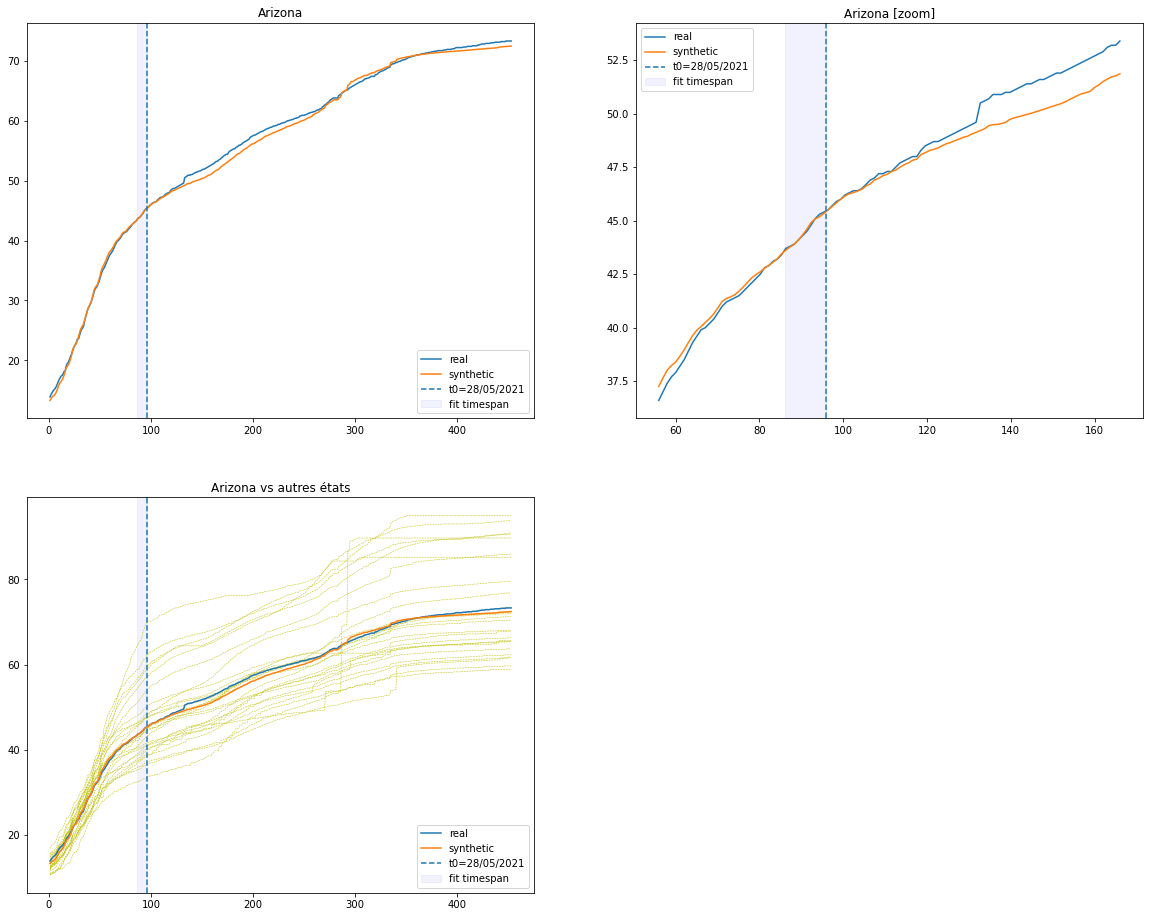


The state of Florida is simulated with:
    Utah 18.9 %
    New Jersey 14.000000000000002 %
    South Dakota 12.3 %
    Texas 10.6 %
    Georgia 10.0 %
    Rhode Island 9.9 %
    West Virginia 8.3 %
    Oklahoma 7.5 %
    Maine 5.2 %
    Idaho 1.3 %


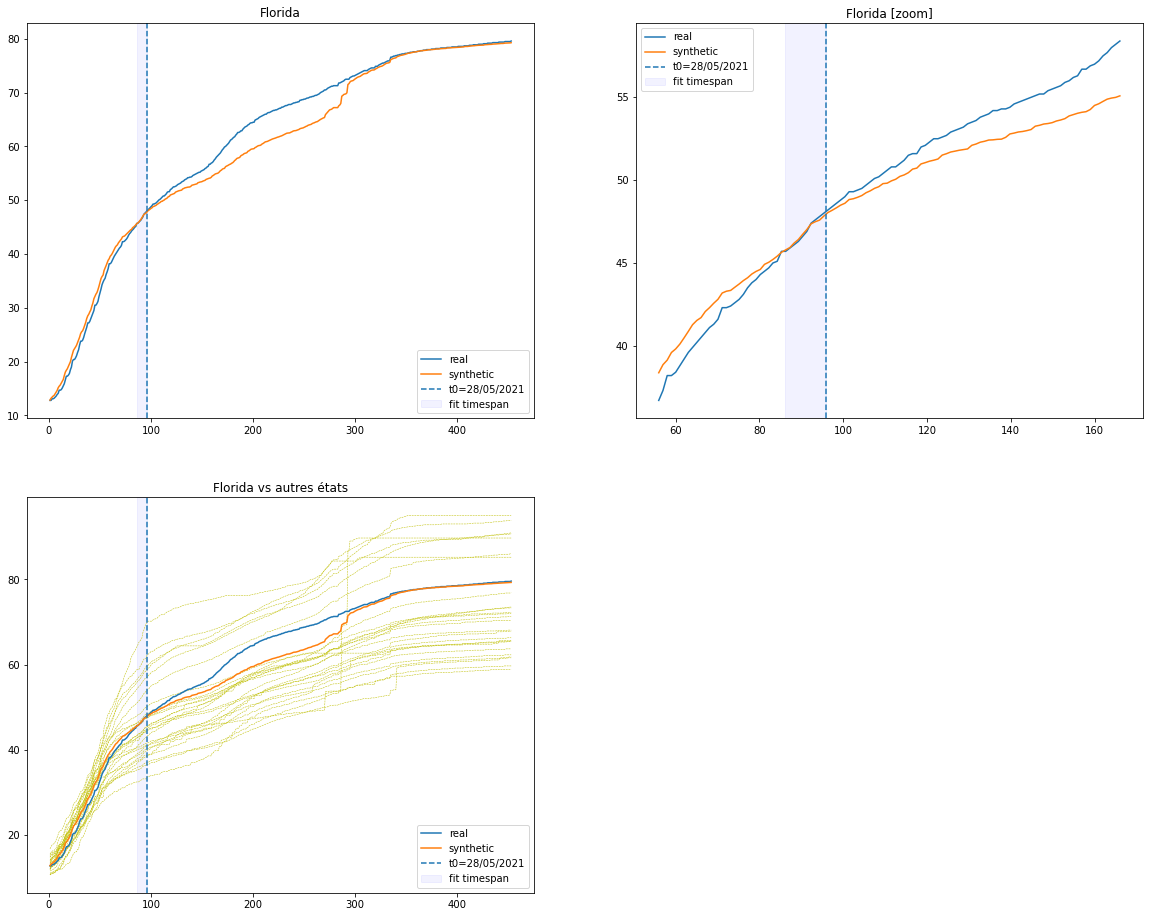


The state of Georgia is simulated with:
    Utah 32.6 %
    Florida 15.0 %
    South Dakota 13.0 %
    Texas 11.700000000000001 %
    North Dakota 11.3 %
    Arizona 9.8 %
    Mississippi 4.7 %
    Iowa 1.0 %


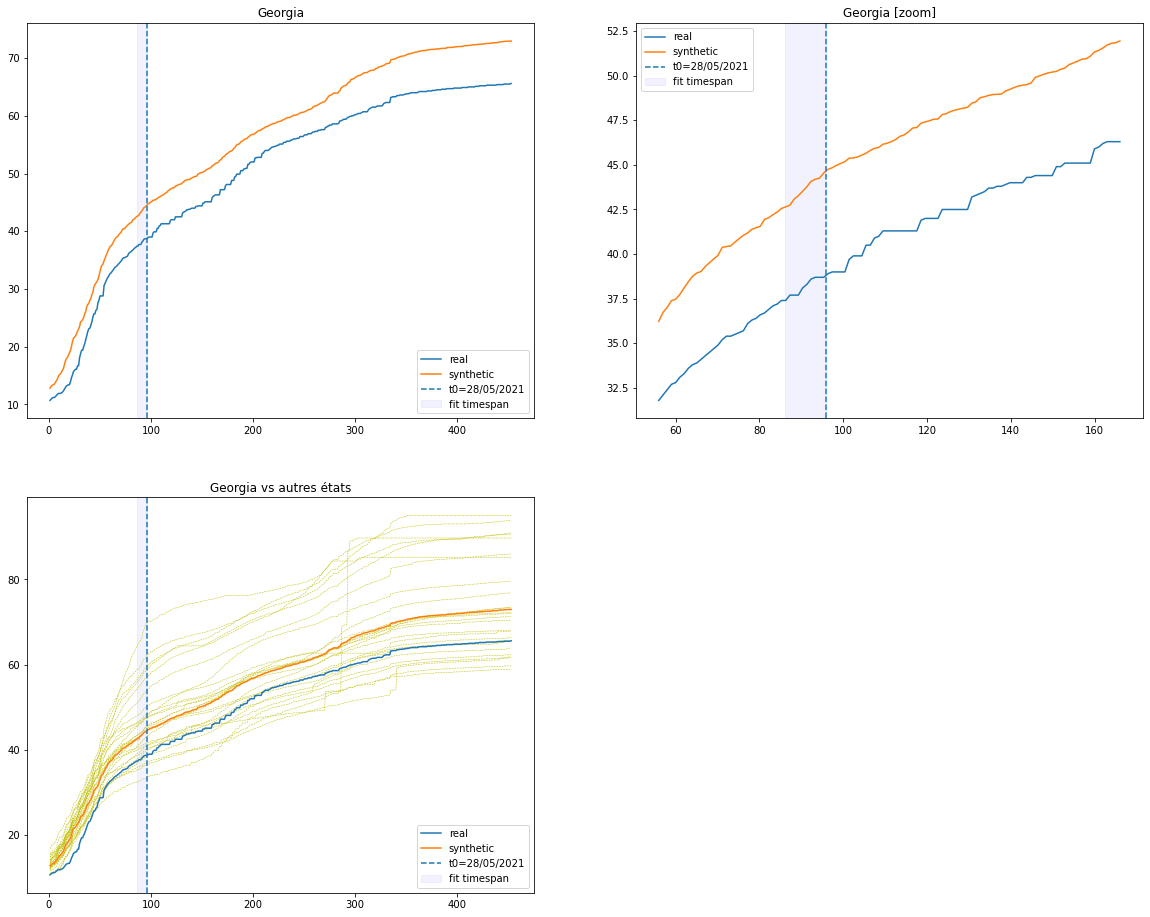


The state of Iowa is simulated with:
    Virginia 20.5 %
    Pennsylvania 14.799999999999999 %
    Montana 12.9 %
    Nebraska 12.7 %
    West Virginia 12.4 %
    Ohio 12.2 %
    Wyoming 3.9 %
    Tennessee 3.6999999999999997 %
    Vermont 3.6999999999999997 %
    Utah 3.2 %


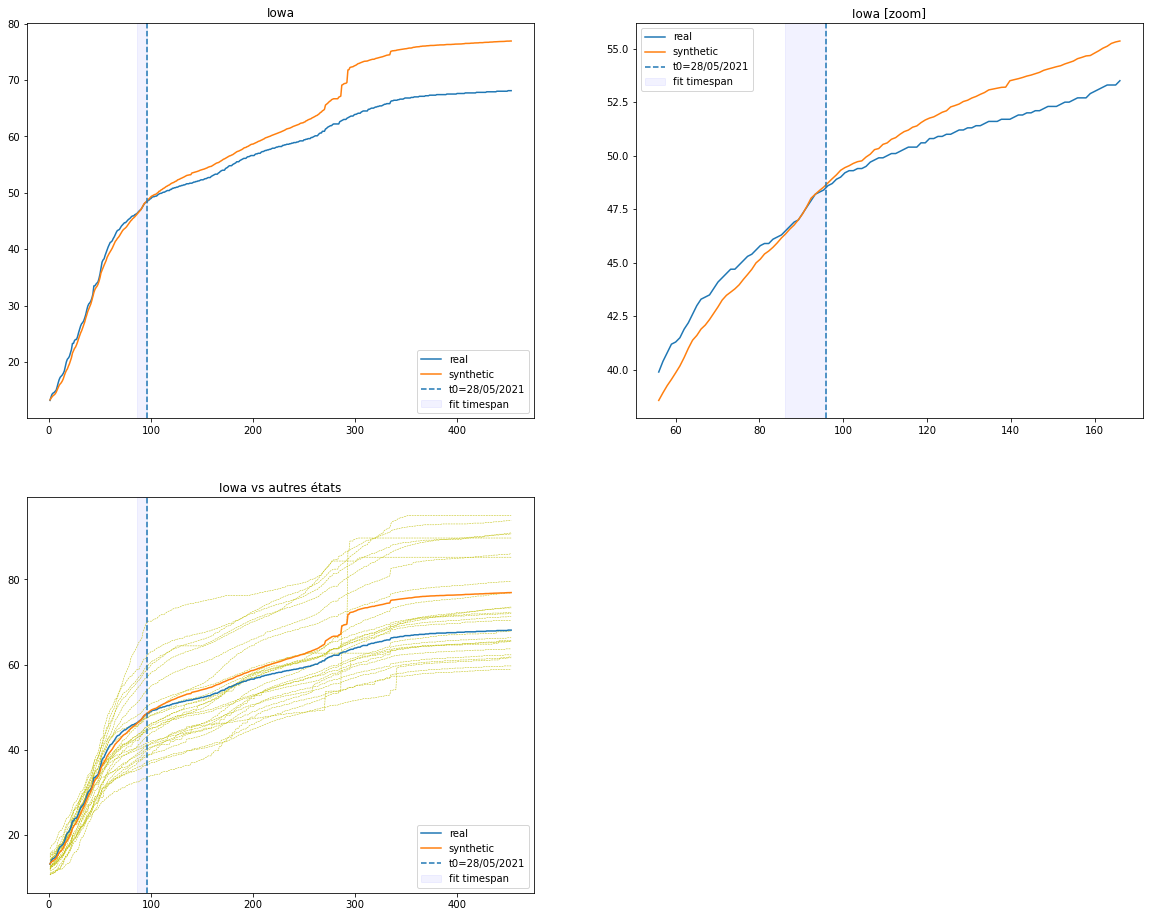


The state of Idaho is simulated with:
    Mississippi 16.7 %
    North Dakota 15.1 %
    Arizona 13.100000000000001 %
    South Dakota 10.9 %
    Texas 10.9 %
    Georgia 7.8 %
    Oklahoma 6.2 %
    Rhode Island 5.7 %
    Kentucky 5.5 %
    Florida 3.0 %
    Utah 3.0 %
    West Virginia 2.0 %


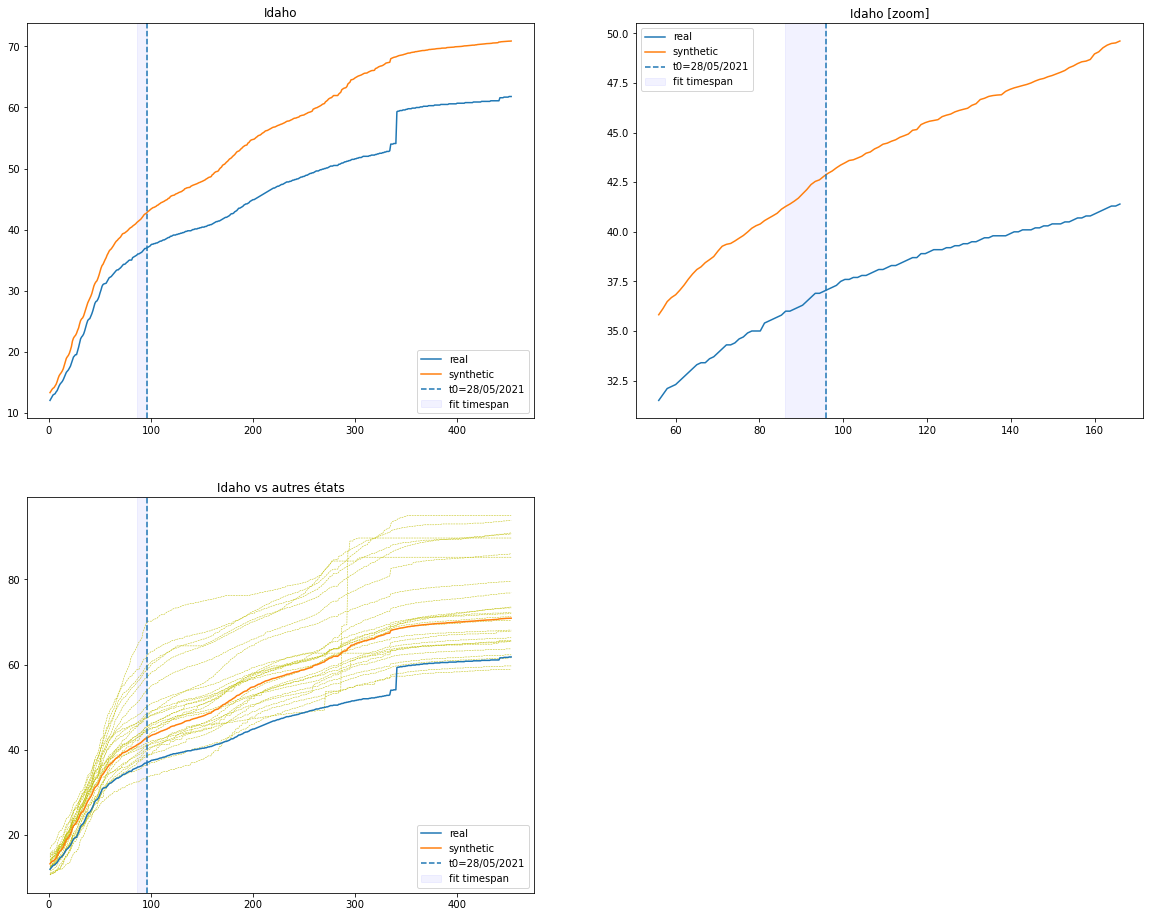


The state of Indiana is simulated with:
    Ohio 19.6 %
    Tennessee 19.1 %
    Mississippi 16.0 %
    Wyoming 15.299999999999999 %
    Oklahoma 8.1 %
    Iowa 6.9 %
    Nebraska 5.4 %
    Kentucky 3.6999999999999997 %
    West Virginia 3.4000000000000004 %
    Virginia 1.5 %


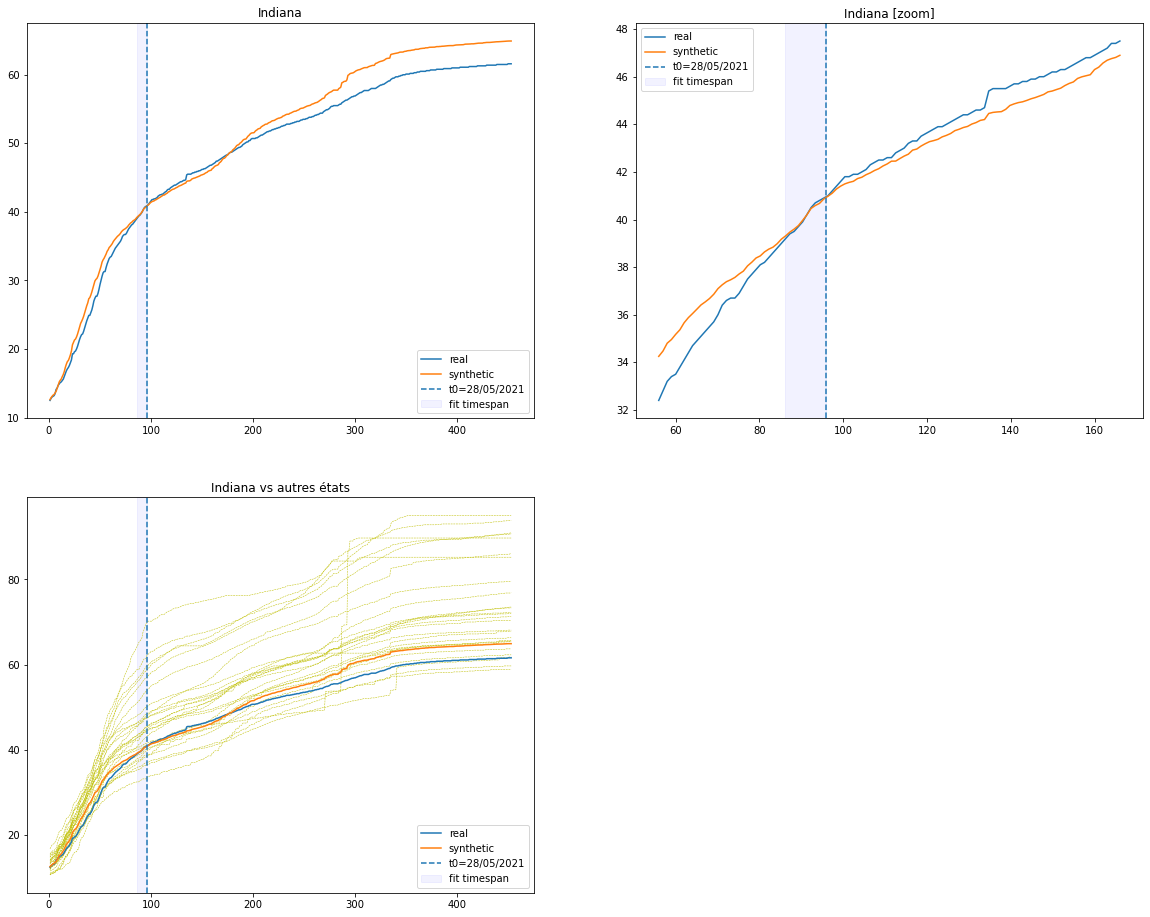


The state of Mississippi is simulated with:
    North Dakota 53.400000000000006 %
    Idaho 43.1 %
    Georgia 2.7 %


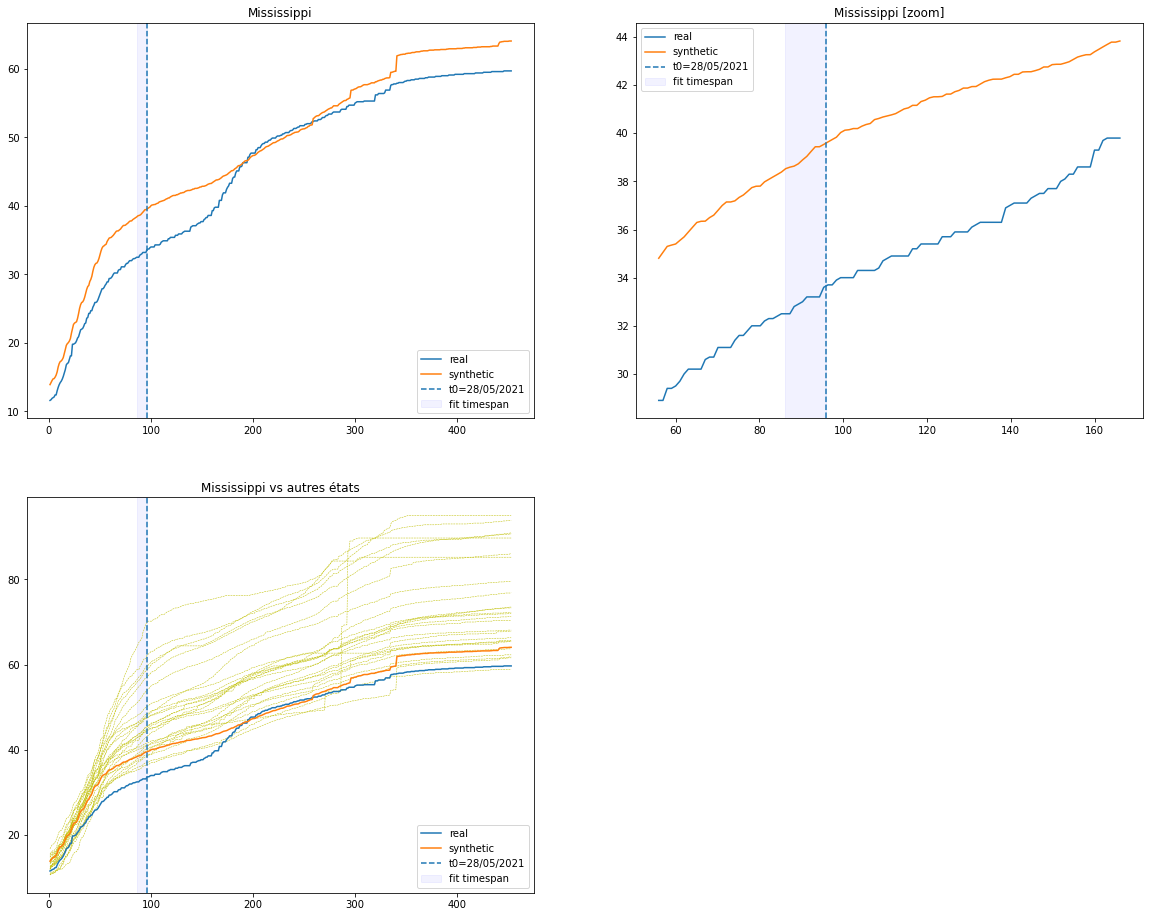


The state of Montana is simulated with:
    Florida 20.7 %
    Mississippi 15.0 %
    Rhode Island 13.100000000000001 %
    Ohio 12.1 %
    Utah 11.1 %
    Oklahoma 10.7 %
    Tennessee 8.7 %
    Nebraska 5.7 %
    Wyoming 2.8000000000000003 %


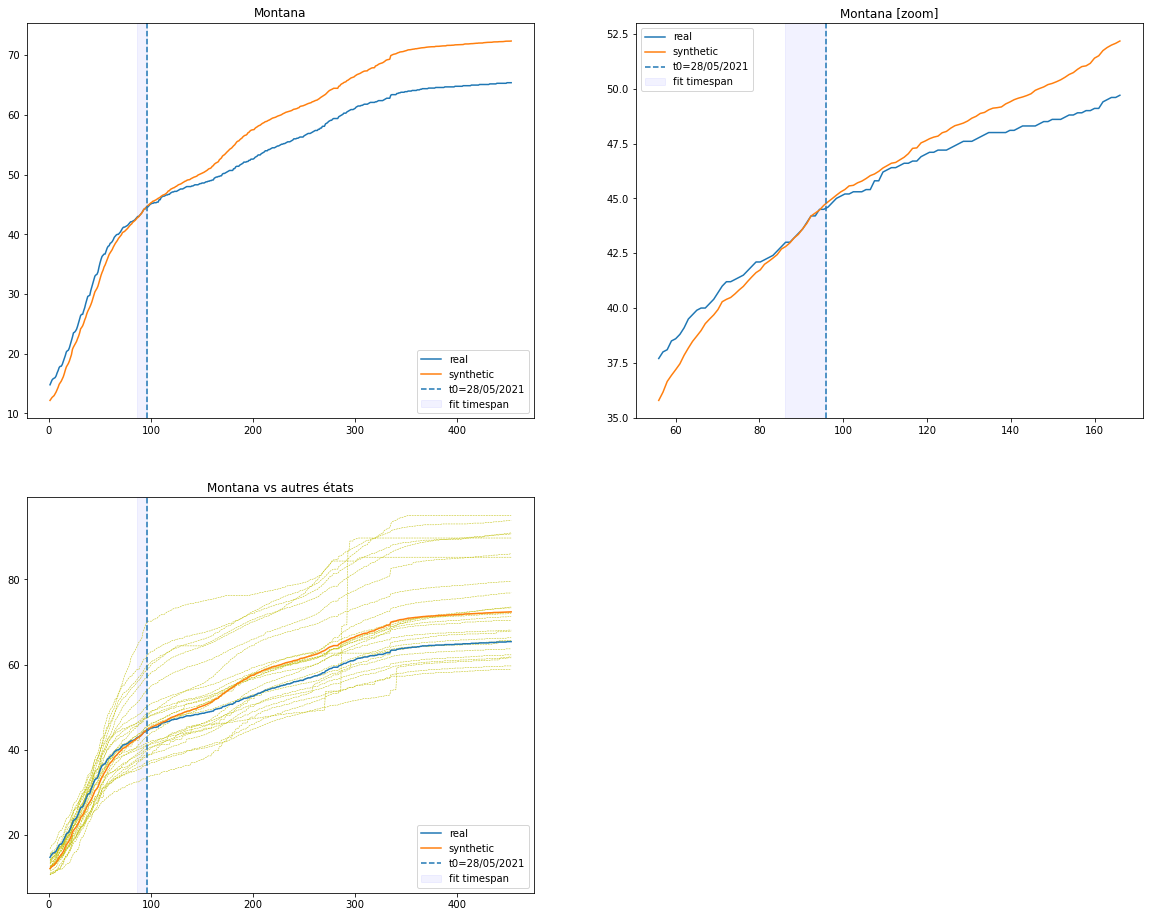


The state of North Dakota is simulated with:
    Arizona 20.5 %
    Idaho 18.5 %
    South Dakota 15.8 %
    Mississippi 15.1 %
    Georgia 13.200000000000001 %
    Oklahoma 5.5 %
    Wisconsin 5.3 %
    Texas 3.8 %
    Rhode Island 2.3 %


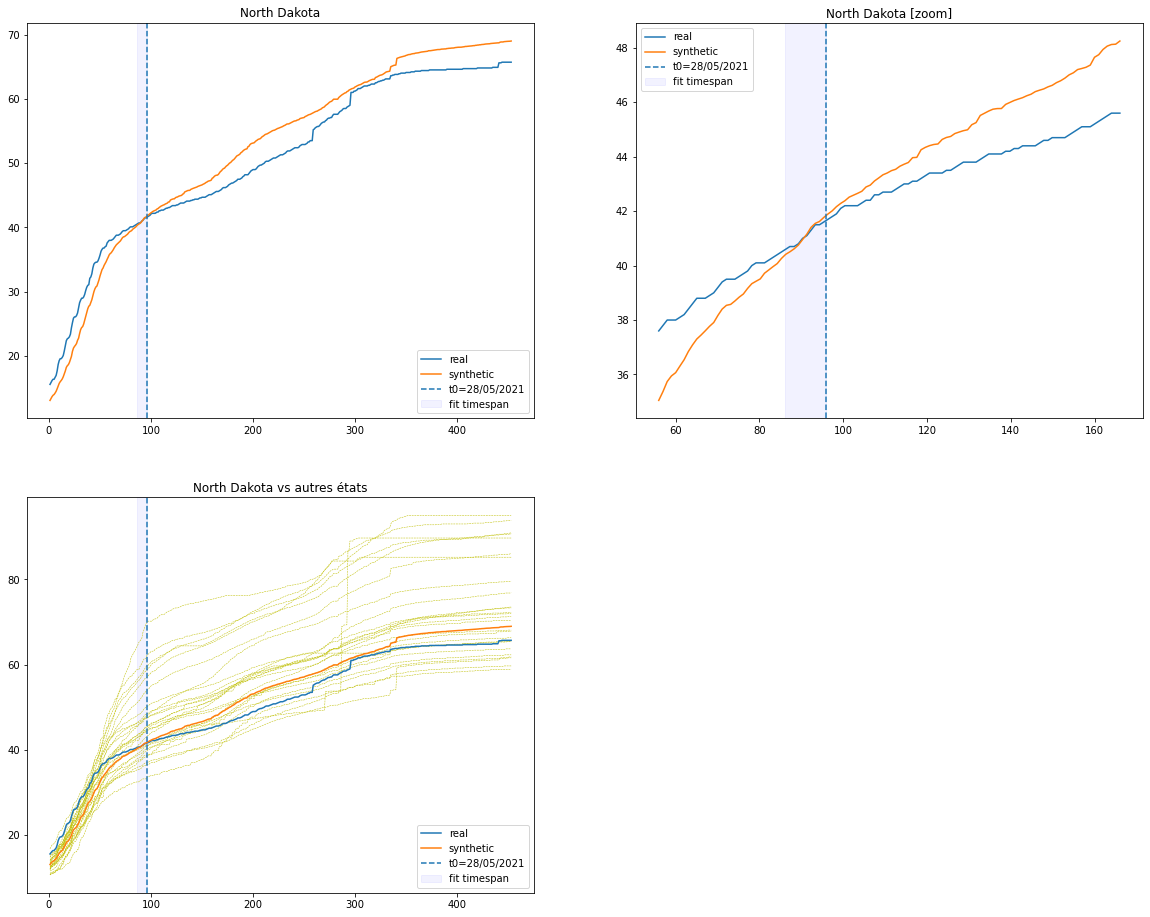


The state of Nebraska is simulated with:
    Idaho 7.3 %
    Wisconsin 7.1 %
    Virginia 6.6000000000000005 %
    Maine 6.2 %
    Indiana 5.6000000000000005 %
    Vermont 5.5 %
    North Dakota 5.4 %
    Pennsylvania 5.2 %
    Wyoming 5.0 %
    Ohio 4.2 %
    Rhode Island 3.9 %
    South Carolina 3.5999999999999996 %
    Mississippi 3.5000000000000004 %
    Tennessee 3.5000000000000004 %
    New Jersey 3.3000000000000003 %
    Oklahoma 3.3000000000000003 %
    Utah 3.1 %
    Georgia 2.9000000000000004 %
    South Dakota 2.6 %
    Florida 2.5 %
    Iowa 2.4 %
    Texas 1.9 %
    Kentucky 1.6 %
    Montana 1.6 %
    Arizona 1.5 %


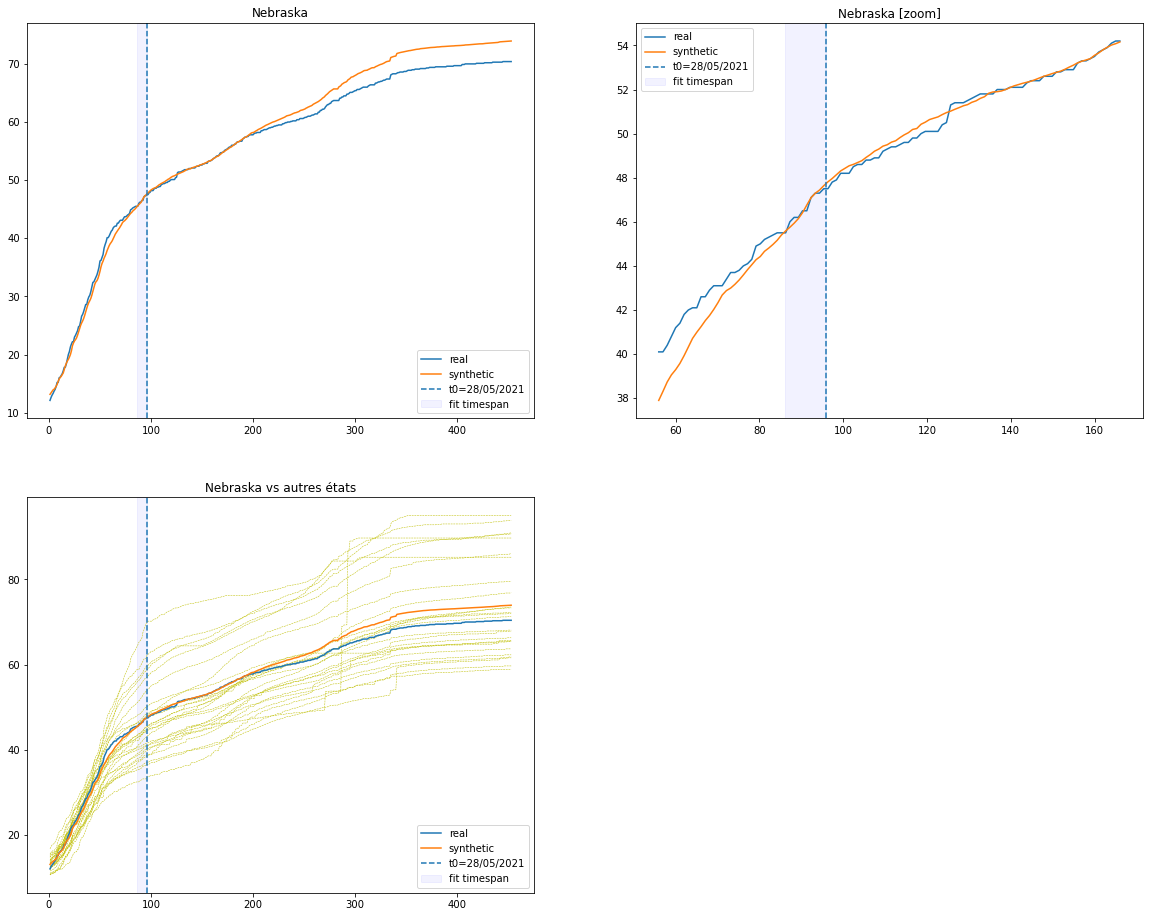


The state of Oklahoma is simulated with:
    Mississippi 18.4 %
    South Carolina 12.8 %
    Indiana 8.9 %
    Wyoming 8.9 %
    South Dakota 8.3 %
    Arizona 7.9 %
    North Dakota 6.9 %
    Texas 6.4 %
    Tennessee 4.8 %
    Iowa 3.1 %
    Ohio 2.5 %
    Kentucky 2.4 %
    Rhode Island 2.4 %
    Florida 2.0 %
    Pennsylvania 1.7000000000000002 %
    Idaho 1.3 %


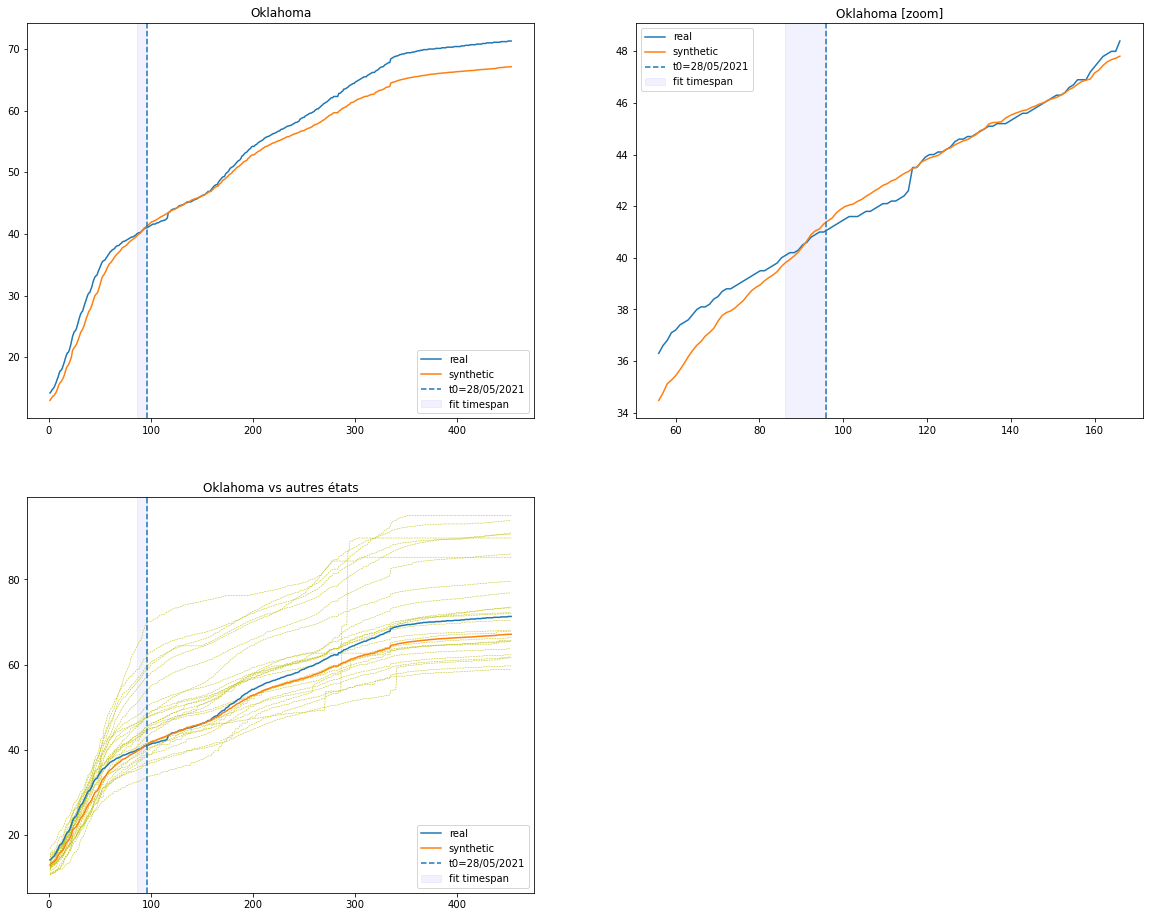


The state of Pennsylvania is simulated with:
    Vermont 17.599999999999998 %
    Maine 15.4 %
    Wisconsin 12.6 %
    South Carolina 7.7 %
    Idaho 7.6 %
    New Jersey 6.6000000000000005 %
    North Dakota 5.5 %
    Virginia 5.0 %
    Nebraska 4.6 %
    Wyoming 4.5 %
    Rhode Island 4.3999999999999995 %
    Florida 3.6999999999999997 %
    Georgia 1.7999999999999998 %
    Indiana 1.7999999999999998 %
    Oklahoma 1.0 %


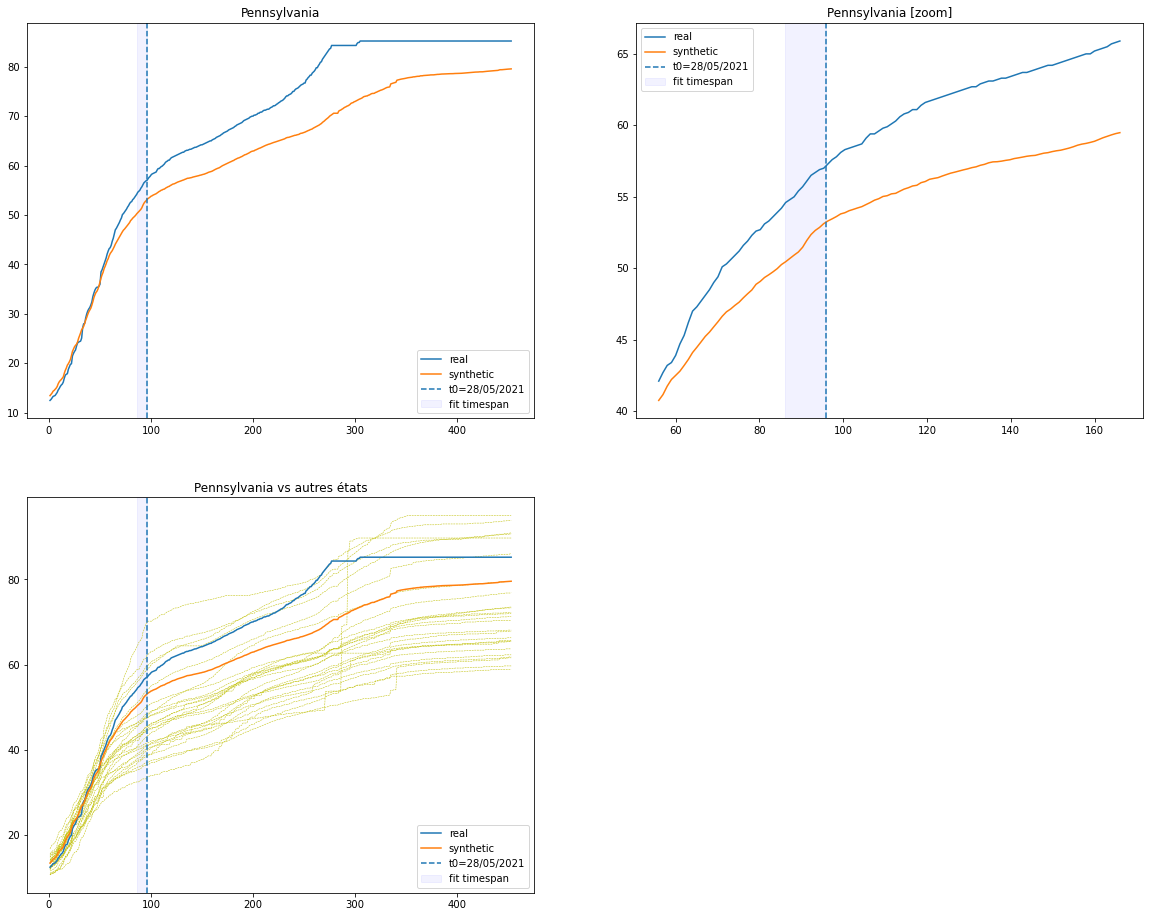


The state of Rhode Island is simulated with:
    Maine 26.1 %
    New Jersey 20.200000000000003 %
    Vermont 20.200000000000003 %
    Florida 18.6 %
    Pennsylvania 6.3 %
    Nebraska 3.5999999999999996 %
    Indiana 2.1 %
    Montana 1.7999999999999998 %


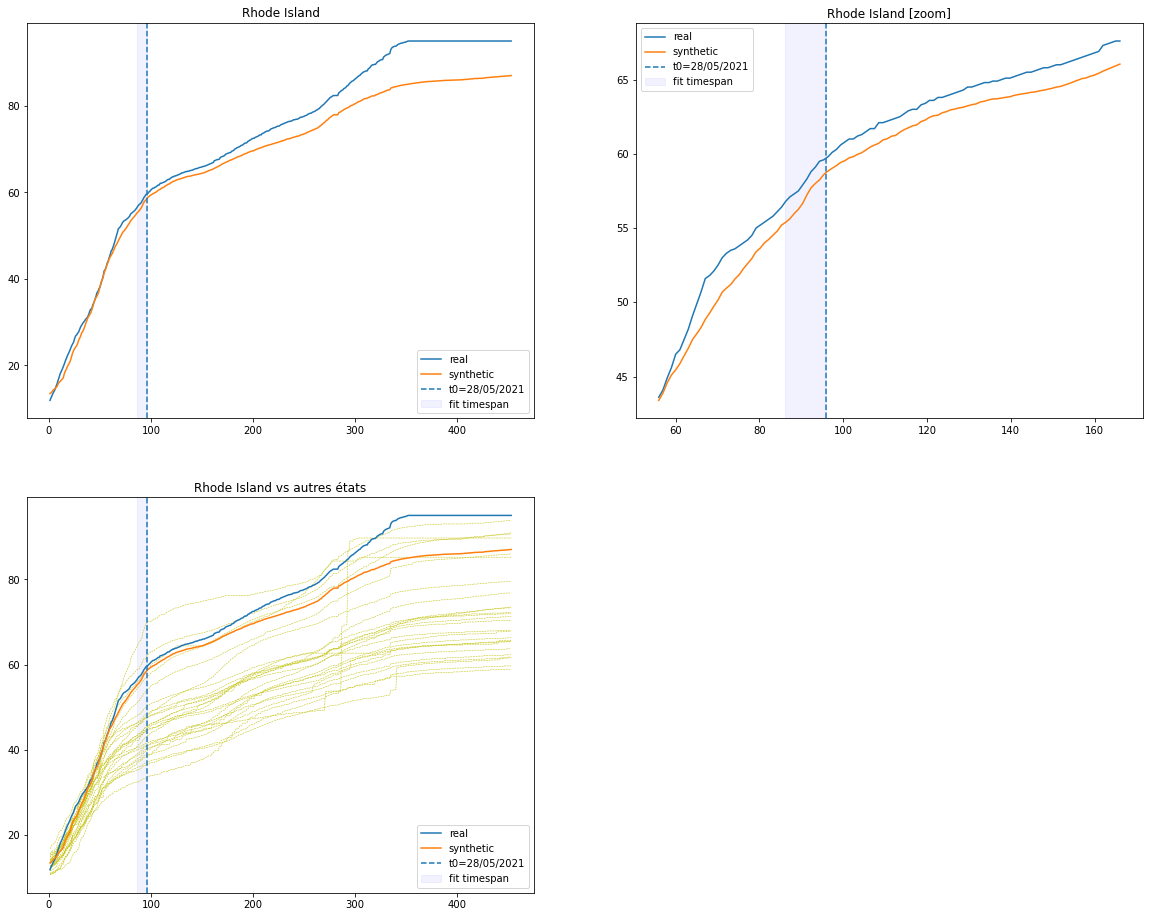


The state of South Carolina is simulated with:
    Ohio 27.900000000000002 %
    Tennessee 25.0 %
    Montana 11.600000000000001 %
    Iowa 5.1 %
    West Virginia 4.1000000000000005 %
    Indiana 4.1000000000000005 %
    Arizona 3.9 %
    Nebraska 3.9 %
    North Dakota 3.8 %
    Vermont 3.1 %
    Kentucky 1.4000000000000001 %
    New Jersey 1.2 %
    Virginia 1.0999999999999999 %
    South Dakota 1.0999999999999999 %


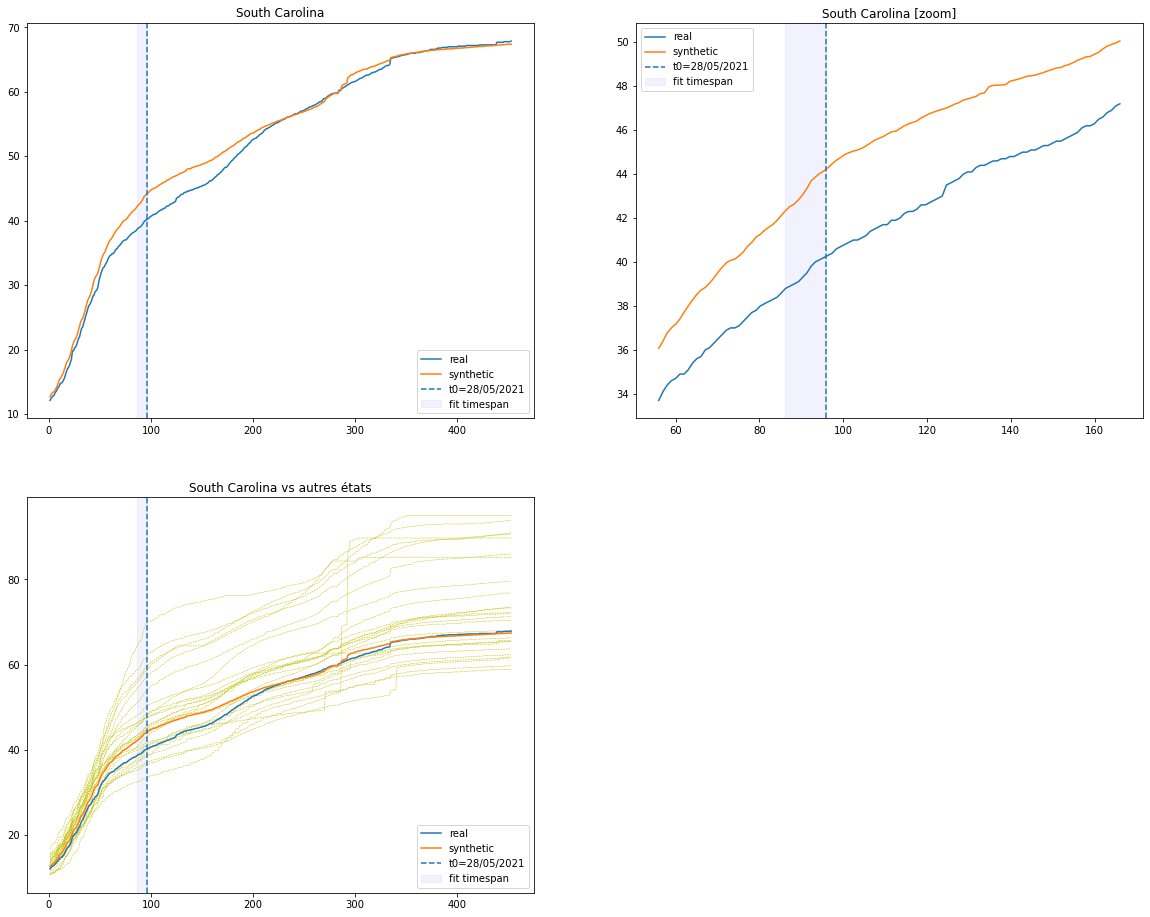


The state of South Dakota is simulated with:
    Vermont 5.2 %
    Nebraska 5.0 %
    Florida 4.8 %
    South Carolina 4.8 %
    Maine 4.7 %
    West Virginia 4.6 %
    Rhode Island 4.5 %
    Pennsylvania 4.3999999999999995 %
    Montana 4.1000000000000005 %
    New Jersey 4.0 %
    Wisconsin 4.0 %
    Texas 4.0 %
    Mississippi 3.9 %
    Idaho 3.9 %
    Wyoming 3.9 %
    Oklahoma 3.9 %
    North Dakota 3.8 %
    Kentucky 3.8 %
    Arizona 3.5999999999999996 %
    Georgia 3.5999999999999996 %
    Indiana 3.4000000000000004 %
    Ohio 3.1 %
    Tennessee 2.8000000000000003 %
    Utah 2.7 %
    Iowa 2.6 %
    Virginia 1.0999999999999999 %


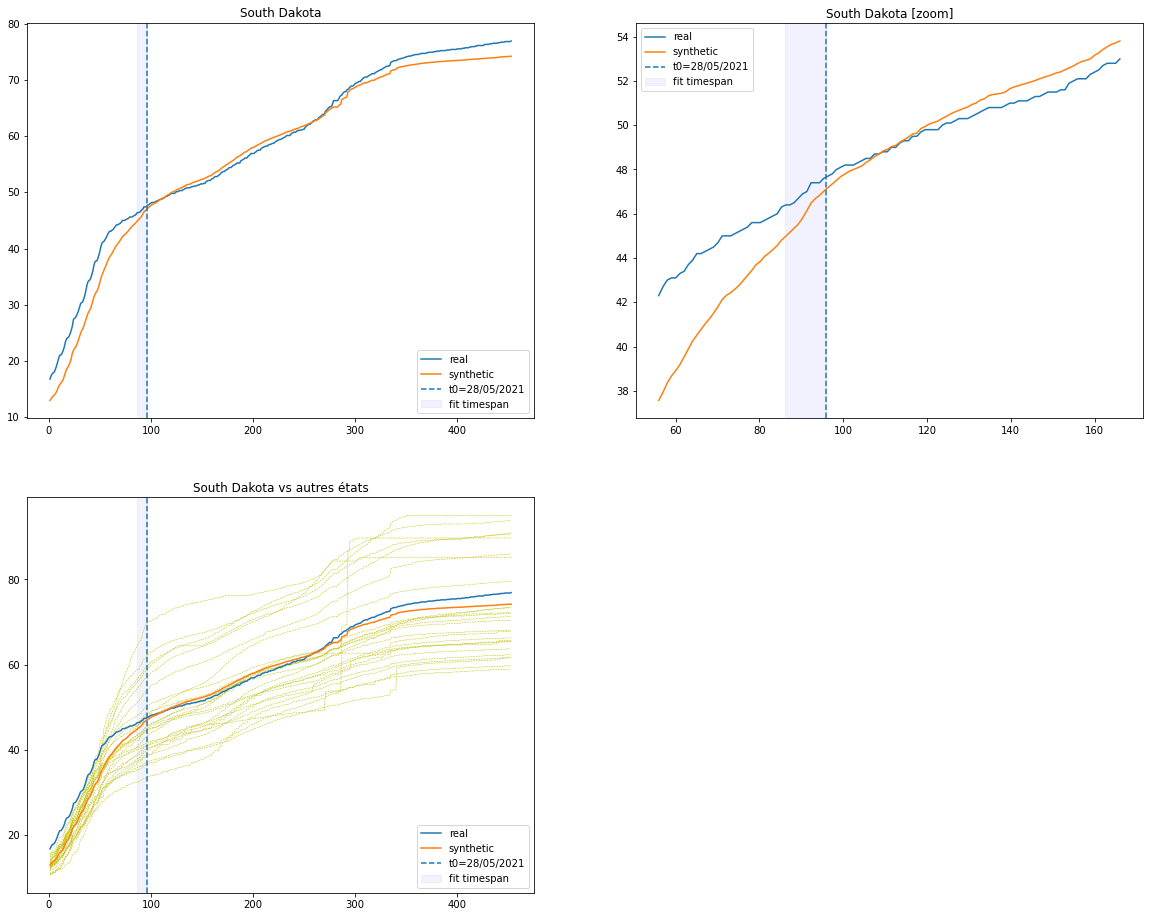


The state of Tennessee is simulated with:


KeyboardInterrupt: 

In [50]:
placebo_synthetic(ls_dose1, 'IL', state_vector_scaled, t_fit=10, t_test=0, classe='All', plot=True)


In [ ]:
print(p_value(ls_dose1["All"], y1_prediction_1))


In [ ]:
# Delta placebo between synthetic and real vaccination rates x days after t0
time_delta = [0, 30, 60, 90]
def delta_y_placebo(ls_dose, y1_prediction,state):
  delta = []

  for X in control_states_all:
    t0 = inc_t0[state]
    delta += [[np.round(y1_prediction[X][t0+d] -ls_dose[X][t0+d],2) for d in time_delta]]

  df_delta = pd.DataFrame(delta, index = control_states_all, columns = time_delta)


  return df_delta

In [ ]:
# Placebo Test - Illinois : 

state = 'IL'

dic_placebo30 = {}
dic_delta_placebo30 = {}

dic_placebo40 = {}
dic_delta_placebo40 = {}

dic_placebo50 = {}
dic_delta_placebo50 = {}

dic_placebo60 = {}
dic_delta_placebo60 = {}

V = synthetic_placebo(ls_dose1, state_vector_scaled, 30, state, plot=False)
y1_prediction30 = y1_prediction_1.copy()
dic_placebo30[state] = y1_prediction30
dic_delta_placebo30[state] = delta_y_placebo(ls_dose1, y1_prediction30, state)

V = synthetic_placebo(ls_dose1, state_vector_scaled, 40, state, plot=True)
y1_prediction40 = y1_prediction_1.copy()
dic_placebo40[state] = y1_prediction40
dic_delta_placebo40[state] = delta_y_placebo(ls_dose1, y1_prediction40, state)

V = synthetic_placebo(ls_dose1, state_vector_scaled, 50, state, plot=False)
y1_prediction50 = y1_prediction_1.copy()
dic_placebo50[state] = y1_prediction50
dic_delta_placebo50[state] = delta_y_placebo(ls_dose1, y1_prediction50, state)

V = synthetic_placebo(ls_dose1, state_vector_scaled, 60, state, plot=False)
y1_prediction60 = y1_prediction_1.copy()
dic_placebo60[state] = y1_prediction60
dic_delta_placebo60[state] = delta_y_placebo(ls_dose1, y1_prediction60, state)

dics_delta = [df_delta30, df_delta40, df_delta50, df_delta60]
dics_placebo = [dic_placebo30, dic_placebo40, dic_placebo50, dic_placebo60]
dics_delta_placebo = [dic_delta_placebo30, dic_delta_placebo40, dic_delta_placebo50, dic_delta_placebo60]



In [ ]:
dic_placebo30[state]

In [ ]:
df_placebo30 = pd.DataFrame.from_dict(dic_placebo30[state])
df_delta_placebo30 =  pd.DataFrame.from_dict(dic_delta_placebo30[state])

df_placebo40 = pd.DataFrame.from_dict(dic_placebo40[state])
df_delta_placebo40 =  pd.DataFrame.from_dict(dic_delta_placebo40[state])

df_placebo50 = pd.DataFrame.from_dict(dic_placebo50[state])
df_delta_placebo50 =  pd.DataFrame.from_dict(dic_delta_placebo50[state])

df_placebo60 = pd.DataFrame.from_dict(dic_placebo60[state])
df_delta_placebo60 =  pd.DataFrame.from_dict(dic_delta_placebo60[state])
 
df_placebo30.to_csv('Résultats/df_placebo30.csv', ',', header=True, index=True)
df_delta_placebo30.to_csv('Résultats/df_delta_placebo30.csv', ',', header=True, index=True)

df_placebo40.to_csv('Résultats/df_placebo40.csv', ',', header=True, index=True)
df_delta_placebo40.to_csv('Résultats/df_delta_placebo40.csv', ',', header=True, index=True)

df_placebo50.to_csv('Résultats/df_placebo50.csv', ',', header=True, index=True)
df_delta_placebo50.to_csv('Résultats/df_delta_placebo50.csv', ',', header=True, index=True)

df_placebo60.to_csv('Résultats/df_placebo60.csv', ',', header=True, index=True)
df_delta_placebo60.to_csv('Résultats/df_delta_placebo60.csv', ',', header=True, index=True)

In [ ]:
fig = plt.figure(figsize=(20, 16))
outer = gd.GridSpec(2, 2, wspace=0.32, hspace=0.32)

for i in range(4):
        inner = gd.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outer[i], wspace=0.3, hspace=0.3, )

        for j in range(4):
            days = [0, 30, 60, 90]
            fitting = [30, 40 , 50 , 60]
            ax = plt.Subplot(fig, inner[j])
            X = list(dics_delta_placebo[i][state][days[j]])
            Z = X + [dics_delta[j].loc[state][days[j]]]
            t = ax.hist(Z, bins = 40)
            p = np.percentile(Z, 95)
            ax.axvline(x = p, color = "red", label = "95th percentile")
            ax.axvline(x = dics_delta[j].loc[state][days[j]], color = "green", label = str(state))
            ax.set_title("Delta at " + str(days[j]) + " day(s) (" + str(fitting[i]) + " fitting days)")
            fig.add_subplot(ax)

fig.suptitle("Placebo Tests for " + str(states_names[state]), y = 0.93, fontsize = 20)
fig.show()


In [ ]:

dic_placebo30 = {}
dic_delta_placebo30 = {}
for state in target_states_all : 
    V = synthetic_placebo(ls_dose1, state_vector_scaled, 30, state, plot=False)
    y1_prediction30 = y1_prediction_1.copy()
    dic_placebo30[state] = y1_prediction30
    dic_delta_placebo30[state] = delta_y_placebo(ls_dose1, y1_prediction30, state)


In [ ]:

dic_placebo40 = {}
dic_delta_placebo40 = {}
for state in target_states_all : 
    V = synthetic_placebo(ls_dose1, state_vector_scaled, 40, state, plot=False)
    y1_prediction40 = y1_prediction_1.copy()
    dic_placebo40[state] = y1_prediction40
    dic_delta_placebo40[state] = delta_y_placebo(ls_dose1, y1_prediction40)


In [ ]:

dic_placebo50 = {}
dic_delta_placebo50 = {}
for state in target_states_all : 
    V = synthetic_placebo(ls_dose1, state_vector_scaled, 50, state, plot=False)
    y1_prediction50 = y1_prediction_1.copy()
    dic_placebo50[state] = y1_prediction50
    dic_delta_placebo50[state] = delta_y_placebo(ls_dose1, y1_prediction50)


In [ ]:

dic_placebo60 = {}
dic_delta_placebo60 = {}
for state in target_states_all : 
    V = synthetic_placebo(ls_dose1, state_vector_scaled, 60, state, plot=False)
    y1_prediction60 = y1_prediction_1.copy()
    dic_placebo60[state] = y1_prediction60
    dic_delta_placebo60[state] = delta_y_placebo(ls_dose1, y1_prediction60)


In [ ]:
# Visualisation histogramme placebo 

dics_delta = [df_delta30, df_delta40, df_delta50, df_delta60]
dics_placebo = [dic_placebo30, dic_placebo40, dic_placebo50, dic_placebo60]
dics_delta_placebo = [dic_delta_placebo30, dic_delta_placebo40, dic_delta_placebo50, dic_delta_placebo60]


for state in target_states_all :
    fig = plt.figure(figsize=(20, 16))
    outer = gd.GridSpec(2, 2, wspace=0.32, hspace=0.32)

    for i in range(4):
            inner = gd.GridSpecFromSubplotSpec(2, 2,
                            subplot_spec=outer[i], wspace=0.3, hspace=0.3, )

            for j in range(4):
                days = [0, 30, 60, 90]
                fitting = [30, 40 , 50 , 60]
                ax = plt.Subplot(fig, inner[j])
                X = list(dics_delta_placebo[i][days[j]])
                Z = X + [dics_delta[j].loc[state][days[j]]]
                t = ax.hist(Z, bins = 30)
                p = np.percentile(Z, 95)
                ax.axvline(x = p, color = "red", label = "95th percentile")
                ax.axvline(x = dics_delta[j].loc[state][days[j]], color = "blue", label = str(state))
                ax.set_title("Delta at " + str(days[j]) + " day(s) (" + str(fitting[j]) + " fitting days)")
                fig.add_subplot(ax)

    fig.suptitle("Placebo Tests for " + str(state), y = 0.93, fontsize = 20)
    fig.show()